In [1]:
# coding: utf-8
%matplotlib inline

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib import mlab
from sklearn.decomposition import PCA

In [2]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql import types as T
from pyspark.sql import functions as F
from pyspark.conf import SparkConf
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.ml.regression import LinearRegression

import multiprocessing

In [3]:
# create SparkContext and SparkSession to process files
cores = multiprocessing.cpu_count() - 2

conf = SparkConf()
conf.setMaster('local[' + str(cores) + ']') \
    .setAppName('example') \
    .set('spark.serializer', 'org.apache.spark.serializer.KryoSerializer') \
    .set('spark.driver.memory', '15g')

sc = SparkContext(conf=conf)
spark = SparkSession(sc)

In [4]:
my_seed = 1980

In [5]:
# csv files' path
my_path = '../data/'

In [6]:
# app customers
app = spark.read.format('csv') \
                .option('sep', ',') \
                .option('header', 'True') \
                .option('inferSchema', 'True') \
                .load(my_path + 'c5_e1_1_app.csv')
app = app.drop('cd_pss', 'nm_mun_uor', 'sg_uf_uor', 'target', 'base_guess')                
# app.createOrReplaceTempView("tab_app")
app.cache()

DataFrame[label: int, v1: int, v2: int, v3: int, v4: int, v5: int, v6: int, v7: int, v8: int, v9: int, v10: int, v11: int, v12: int, v13: int, v14: int, v15: int, v16: int, v17: int, v18: int, v19: int, v20: int, v21: int, v22: int, v23: int, v24: int, v25: int, v26: int, v27: int, v28: double, v29: double, v30: double, v31: double, v32: double, v33: double, v34: double, v35: double, v36: double, v37: double, v38: double, v39: double, v40: double, v41: double, v42: double, v43: double, v44: double, v45: double, v46: double, v47: double, v48: double, v49: double, v50: double, v51: double, v52: double, v53: double, v54: double, v55: double, v56: double, v57: double, v58: double, v59: double, v60: int, v61: int, v62: int, v63: int, v64: int, v65: int, v66: int, v67: int, v68: int, v69: int, v70: int, v71: int, v72: int, v73: int, v74: int, v75: int, v76: int, v77: int, v78: int, v79: int, v80: int, v81: int, v82: int, v83: int, v84: int, v85: int, v86: int, v87: int, v88: int, v89: int, v

In [7]:
app_rdd = app.rdd.map(tuple)

In [8]:
from pyspark.mllib.stat import Statistics

pearsonCorr = Statistics.corr(app_rdd)

print(pearsonCorr)

[[ 1.         -0.06229028  0.18167475 ... -0.00644571 -0.01036431
  -0.00283739]
 [-0.06229028  1.         -0.01355278 ...  0.00457458  0.01651404
   0.01556293]
 [ 0.18167475 -0.01355278  1.         ... -0.00709967 -0.0059259
   0.00457519]
 ...
 [-0.00644571  0.00457458 -0.00709967 ...  1.         -0.00265932
  -0.00439791]
 [-0.01036431  0.01651404 -0.0059259  ... -0.00265932  1.
  -0.00354414]
 [-0.00283739  0.01556293  0.00457519 ... -0.00439791 -0.00354414
   1.        ]]


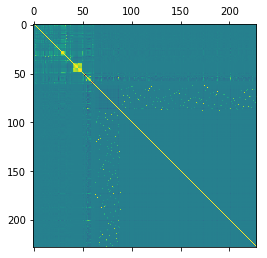

In [9]:
plt.matshow(pearsonCorr)
plt.show()

In [10]:
# checking correlation between attributes and label
corr_pd = pd.DataFrame(pearsonCorr, columns=app.columns)
np.abs(corr_pd['label']).sort_values(ascending=False)[:15]

0     1.000000
50    0.378106
10    0.298790
33    0.288926
31    0.272257
30    0.266746
38    0.253740
29    0.243281
3     0.236802
32    0.221845
13    0.190488
17    0.184648
12    0.183631
2     0.181675
34    0.181121
Name: label, dtype: float64

In [11]:
# checking multicolinearity
matrix = corr_pd.as_matrix()
size = matrix.shape[0]

In [12]:
for i in range(size):
    for j in range(size):
        if np.abs(matrix[i][j]) > .7 and i < j:
            print(str(i) + ', ' + str(j) + ': ' + str(matrix[i][j]))

29, 30: 0.9411200943378587
29, 31: 0.9045115031192538
30, 31: 0.9186497839590017
41, 42: 0.764792203624683
41, 46: 0.8519959496898721
41, 47: 0.780245749822957
41, 48: 0.7491782040755975
41, 49: 0.7227477395818952
42, 43: 0.8863554326741125
42, 44: 0.832869089263124
42, 45: 0.7876954103256238
42, 46: 0.8544097393140707
42, 47: 0.8422708551153948
42, 48: 0.8278985147265784
42, 49: 0.8082313984501294
43, 44: 0.9503210261148467
43, 45: 0.9042485770103214
43, 46: 0.7307285047951046
43, 47: 0.7586223325304715
43, 48: 0.7812715413546257
43, 49: 0.7831165230924556
44, 45: 0.9603734183589819
44, 47: 0.7009186369630676
44, 48: 0.7367268060922807
44, 49: 0.7550071227040235
45, 49: 0.7136749737307488
46, 47: 0.9478419772671896
46, 48: 0.9055710558446178
46, 49: 0.8653948313576866
47, 48: 0.9742450808594774
47, 49: 0.9318908127621467
48, 49: 0.9741935780634202
52, 53: -0.7749365775675311
54, 58: 0.7387106200740187
55, 87: 0.7911543011428902
57, 58: 0.7408337361036235
63, 174: 0.9230776825452262
64

In [13]:
types = pd.DataFrame(app.dtypes, columns=['var', 'type'])
floats = types.loc[types['type'] == 'double', 'var'].tolist()

In [14]:
size = app.count()

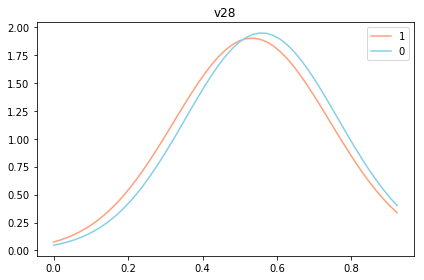

Label = 1 (Mean, Standard-Deviation): (0.5329936536059405, 0.20985629537451375)
Label = 0 (Mean, Standard-Deviation): (0.5592641451679801, 0.20486709569848408)
p-value: 0.0
Null hipothesis rejected



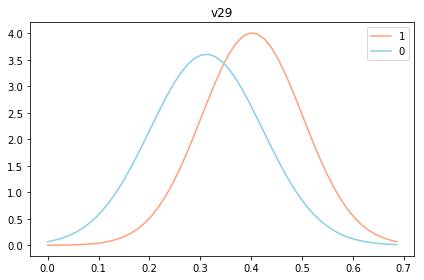

Label = 1 (Mean, Standard-Deviation): (0.40213360014278204, 0.09947761008979665)
Label = 0 (Mean, Standard-Deviation): (0.31198126253722414, 0.11064013791596747)
p-value: 0.0
Null hipothesis rejected



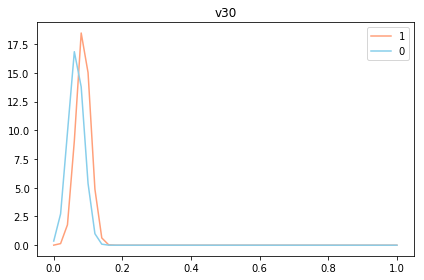

Label = 1 (Mean, Standard-Deviation): (0.08549410487933484, 0.020869439591814472)
Label = 0 (Mean, Standard-Deviation): (0.06458370956239641, 0.023235270531685857)
p-value: 0.0
Null hipothesis rejected



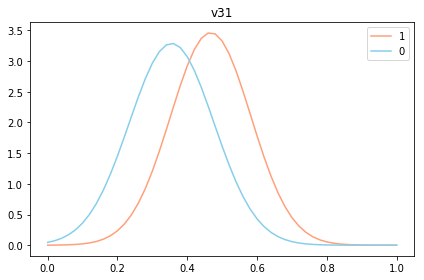

Label = 1 (Mean, Standard-Deviation): (0.46707567129081945, 0.11513835927392126)
Label = 0 (Mean, Standard-Deviation): (0.35502284586366917, 0.12127937064221501)
p-value: 0.0
Null hipothesis rejected



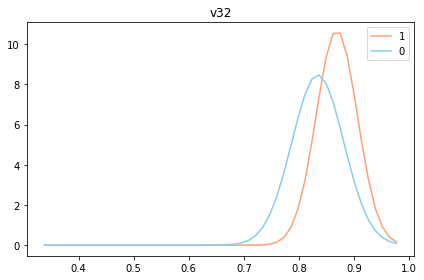

Label = 1 (Mean, Standard-Deviation): (0.8688462101964908, 0.03731415092420106)
Label = 0 (Mean, Standard-Deviation): (0.8344137065494516, 0.047080944081666555)
p-value: 0.0
Null hipothesis rejected



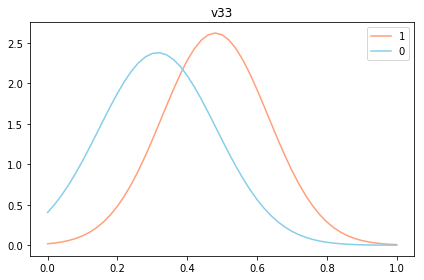

Label = 1 (Mean, Standard-Deviation): (0.480040181122422, 0.15218323587752552)
Label = 0 (Mean, Standard-Deviation): (0.3154520724360942, 0.1677129547552493)
p-value: 0.0
Null hipothesis rejected



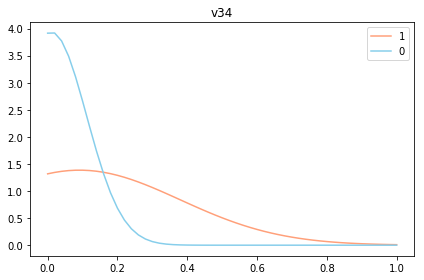

Label = 1 (Mean, Standard-Deviation): (0.09121288069263052, 0.28791118539271265)
Label = 0 (Mean, Standard-Deviation): (0.01038006646775408, 0.10135245772984044)
p-value: 0.0
Null hipothesis rejected



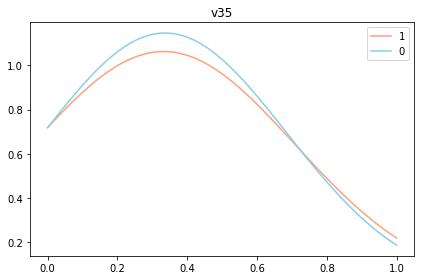

Label = 1 (Mean, Standard-Deviation): (0.3323058232537388, 0.37534259349257126)
Label = 0 (Mean, Standard-Deviation): (0.336741624261691, 0.3479159859362789)
p-value: 7.026833644133356e-17
Null hipothesis rejected



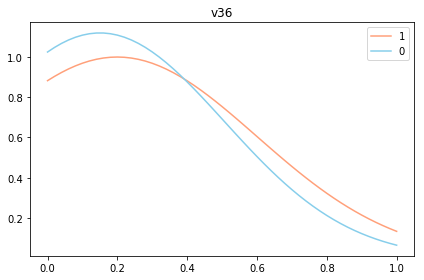

Label = 1 (Mean, Standard-Deviation): (0.19963741393758208, 0.39948991597597916)
Label = 0 (Mean, Standard-Deviation): (0.15016654471544572, 0.3567817378571638)
p-value: 0.0
Null hipothesis rejected



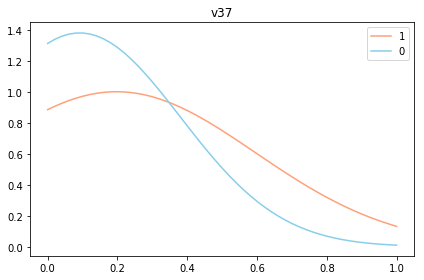

Label = 1 (Mean, Standard-Deviation): (0.19749752699264553, 0.39810035504858166)
Label = 0 (Mean, Standard-Deviation): (0.09172666164720003, 0.2886241999460302)
p-value: 0.0
Null hipothesis rejected



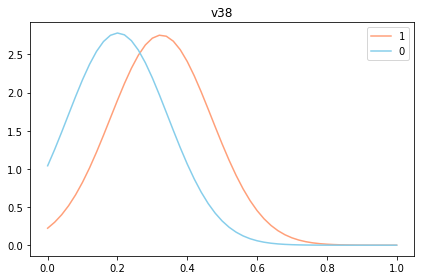

Label = 1 (Mean, Standard-Deviation): (0.3249187728152725, 0.14487580004117934)
Label = 0 (Mean, Standard-Deviation): (0.20110292841361888, 0.14344693927040983)
p-value: 0.0
Null hipothesis rejected



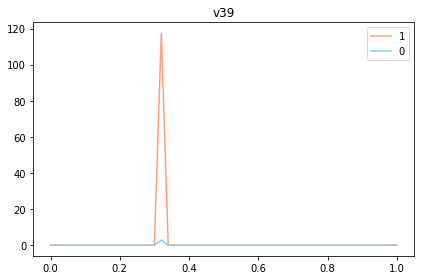

Label = 1 (Mean, Standard-Deviation): (0.3213008468423707, 0.0031102246979722555)
Label = 0 (Mean, Standard-Deviation): (0.32096079469622424, 0.0002721638518912207)
p-value: 0.0
Null hipothesis rejected



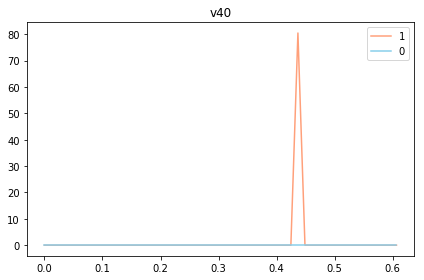

Label = 1 (Mean, Standard-Deviation): (0.43490462534774993, 0.0009346873255175675)
Label = 0 (Mean, Standard-Deviation): (0.43470891876024637, 0.00011674239779743575)
p-value: 0.0
Null hipothesis rejected



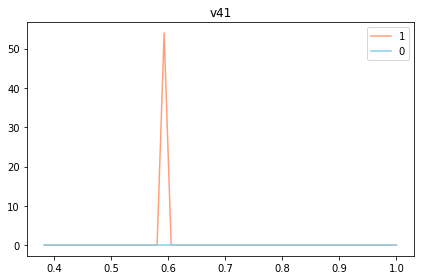

Label = 1 (Mean, Standard-Deviation): (0.5962264296455535, 0.002197377284544818)
Label = 0 (Mean, Standard-Deviation): (0.5959437934320122, 0.0004421667430697139)
p-value: 0.0
Null hipothesis rejected



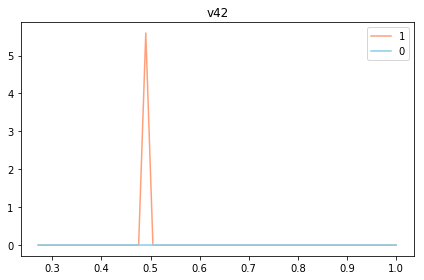

Label = 1 (Mean, Standard-Deviation): (0.4950687553151047, 0.0017236621257808596)
Label = 0 (Mean, Standard-Deviation): (0.4948989469994278, 0.0003778506123906156)
p-value: 0.0
Null hipothesis rejected



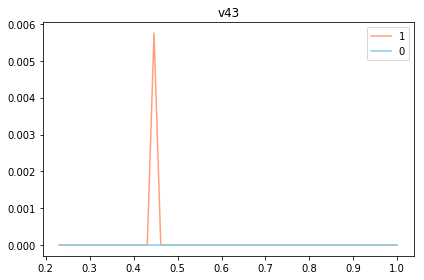

Label = 1 (Mean, Standard-Deviation): (0.453163173380245, 0.001459314904853825)
Label = 0 (Mean, Standard-Deviation): (0.45308800917011577, 0.0003490639903981536)
p-value: 0.0
Null hipothesis rejected



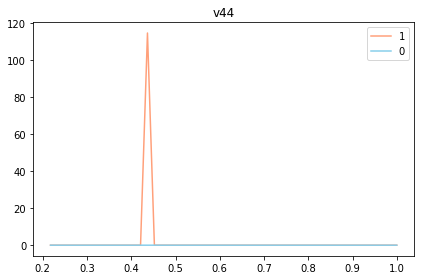

Label = 1 (Mean, Standard-Deviation): (0.4384528986396142, 0.0013725571733982722)
Label = 0 (Mean, Standard-Deviation): (0.43841026882535533, 0.0003276721646373781)
p-value: 3.093777581126726e-178
Null hipothesis rejected



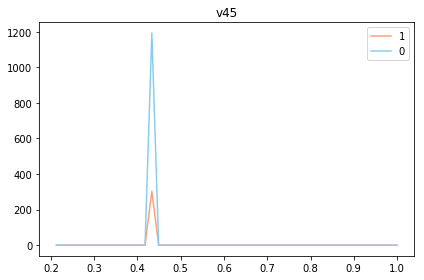

Label = 1 (Mean, Standard-Deviation): (0.4334339235109272, 0.0013104004727380128)
Label = 0 (Mean, Standard-Deviation): (0.4334209525774429, 0.00031361097011421387)
p-value: 1.1692970424904193e-19
Null hipothesis rejected



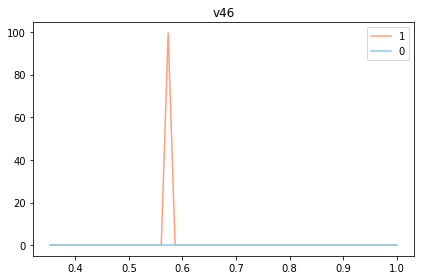

Label = 1 (Mean, Standard-Deviation): (0.5709629375607389, 0.0020890414417940213)
Label = 0 (Mean, Standard-Deviation): (0.5706291249345682, 0.0004268648636793494)
p-value: 0.0
Null hipothesis rejected



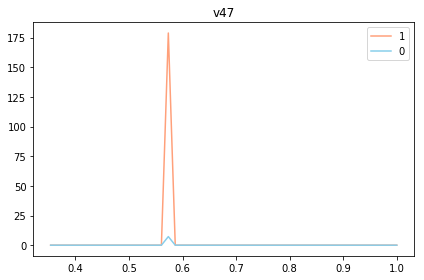

Label = 1 (Mean, Standard-Deviation): (0.5725316911937479, 0.0019911226006928645)
Label = 0 (Mean, Standard-Deviation): (0.5722020222538798, 0.00040860909617724845)
p-value: 0.0
Null hipothesis rejected



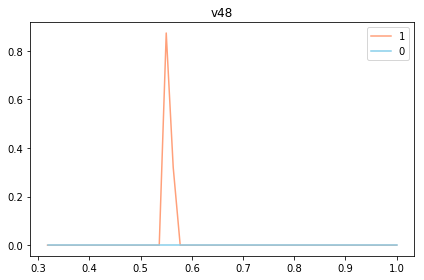

Label = 1 (Mean, Standard-Deviation): (0.5565441907017445, 0.0019793742833879415)
Label = 0 (Mean, Standard-Deviation): (0.5562082577012007, 0.00042703091797223963)
p-value: 0.0
Null hipothesis rejected



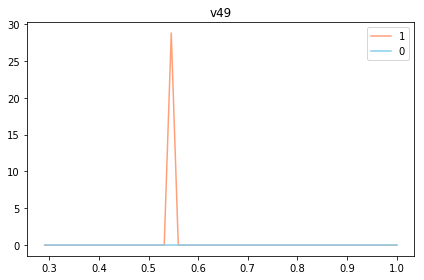

Label = 1 (Mean, Standard-Deviation): (0.5418428813224706, 0.0019504519317191848)
Label = 0 (Mean, Standard-Deviation): (0.541508532404842, 0.000440410076429445)
p-value: 0.0
Null hipothesis rejected



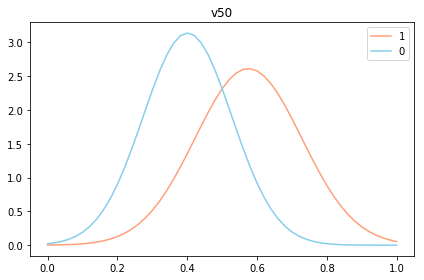

Label = 1 (Mean, Standard-Deviation): (0.5752141027529087, 0.15270160197376137)
Label = 0 (Mean, Standard-Deviation): (0.40080774903725924, 0.1271132081684125)
p-value: 0.0
Null hipothesis rejected



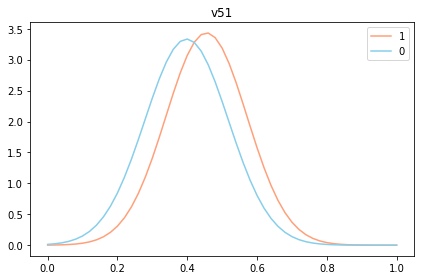

Label = 1 (Mean, Standard-Deviation): (0.45506802453905815, 0.11615778079504063)
Label = 0 (Mean, Standard-Deviation): (0.398273756857483, 0.11964240899196953)
p-value: 0.0
Null hipothesis rejected



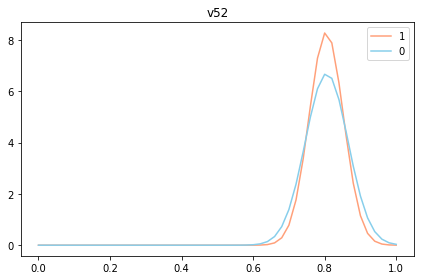

Label = 1 (Mean, Standard-Deviation): (0.8045015115526217, 0.04802457946809678)
Label = 0 (Mean, Standard-Deviation): (0.8057106010680359, 0.05960416105593972)
p-value: 4.705248528506468e-53
Null hipothesis rejected



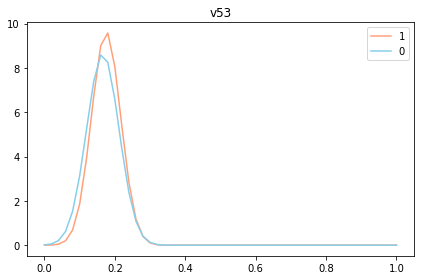

Label = 1 (Mean, Standard-Deviation): (0.17518360943049563, 0.04138281043961246)
Label = 0 (Mean, Standard-Deviation): (0.16586456402878563, 0.04612130011396803)
p-value: 0.0
Null hipothesis rejected



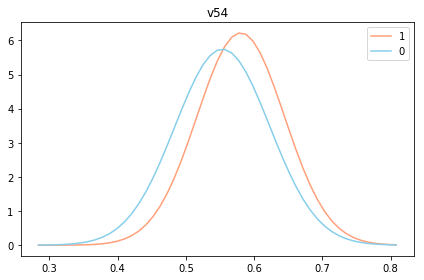

Label = 1 (Mean, Standard-Deviation): (0.5803605776004069, 0.06411266490753068)
Label = 0 (Mean, Standard-Deviation): (0.5534868164947372, 0.06945530531081957)
p-value: 0.0
Null hipothesis rejected



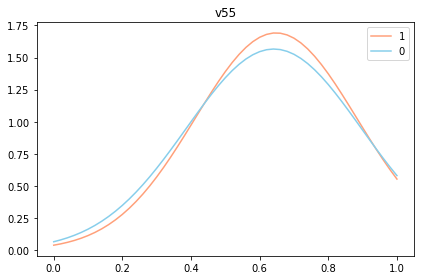

Label = 1 (Mean, Standard-Deviation): (0.6476673199648184, 0.2357428501232307)
Label = 0 (Mean, Standard-Deviation): (0.6412414145778595, 0.2546438903548825)
p-value: 1.0528694201637614e-71
Null hipothesis rejected



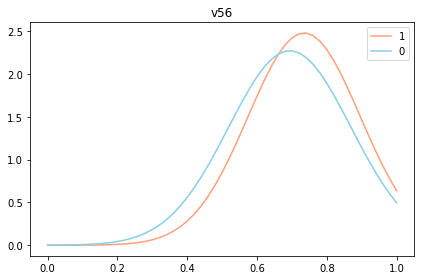

Label = 1 (Mean, Standard-Deviation): (0.7350157880535706, 0.16067938208976562)
Label = 0 (Mean, Standard-Deviation): (0.6937985008757819, 0.1754100030611424)
p-value: 0.0
Null hipothesis rejected



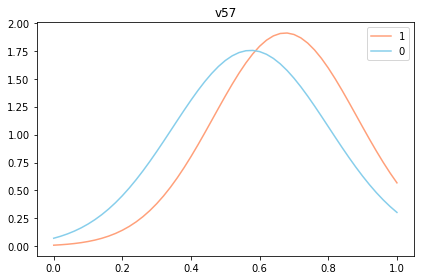

Label = 1 (Mean, Standard-Deviation): (0.674806710674531, 0.20886823045264483)
Label = 0 (Mean, Standard-Deviation): (0.5740936389195167, 0.2274251646828946)
p-value: 0.0
Null hipothesis rejected



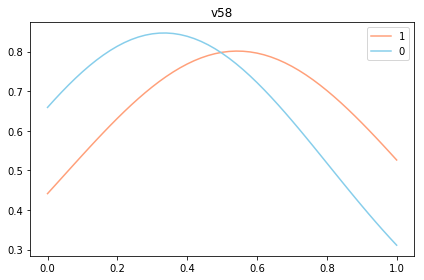

Label = 1 (Mean, Standard-Deviation): (0.5435744813069451, 0.4979110823181374)
Label = 0 (Mean, Standard-Deviation): (0.3336245307908757, 0.47106258413257845)
p-value: 0.0
Null hipothesis rejected



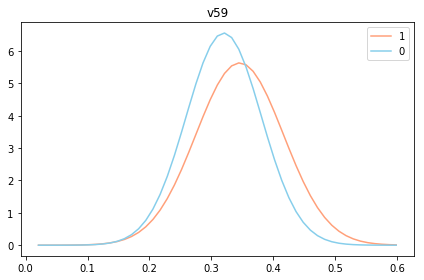

Label = 1 (Mean, Standard-Deviation): (0.3457236731244784, 0.07080294718787732)
Label = 0 (Mean, Standard-Deviation): (0.32008491316661886, 0.06082961851340257)
p-value: 0.0
Null hipothesis rejected

['v29', 'v31', 'v33', 'v34', 'v37', 'v38', 'v50', 'v51', 'v57', 'v58']


In [33]:
useful = []
for f in floats:
    f1 = [float(x) for x in app.where(app['label'] == 1).select(f).rdd.flatMap(lambda x: x).collect()]
    mu1 = np.mean(f1)
    sd1 = np.std(f1)    
    
    s0 = app.where(app.label == 0).select(f).sample(True, len(f1) / float(size), seed=my_seed)
    f0 = [float(x) for x in s0.rdd.flatMap(lambda x: x).collect()]
    mu0 = np.mean(f0)
    sd0= np.std(f0)  
    
    num_bins = 50
    fig, ax = plt.subplots()
    
    # the histogram of the data
    hist, bins = np.histogram(f1 + f0, num_bins)
    
    # add a 'best fit' line
    y1 = ((1 / (np.sqrt(2 * np.pi) * sd1)) *
         np.exp(-0.5 * (1 / sd1 * (bins - mu1))**2))
    ax.plot(bins, y1, 'lightsalmon', label='1')    
    
    y0 = ((1 / (np.sqrt(2 * np.pi) * sd0)) *
         np.exp(-0.5 * (1 / sd0 * (bins - mu0))**2)) 
    ax.plot(bins, y0, 'skyblue', label='0')
    
    ax.legend()
    
#     ax.set_xlabel('Smarts')
#     ax.set_ylabel('Probability density')
    ax.set_title(f)

    # Tweak spacing to prevent clipping of ylabel
    fig.tight_layout()
    plt.show()
    
    print('Label = 1 (Mean, Standard-Deviation): (' + str(mu1) + ', ' + str(sd1) + ')')
    print('Label = 0 (Mean, Standard-Deviation): (' + str(mu0) + ', ' + str(sd0) + ')')

    D, p = stats.ttest_ind(f0, f1)
    
    print('p-value: ' + str(p))
    
    if p < 0.05:
        print('Null hipothesis rejected')
        if (np.abs(mu1 - mu0) > 0.05):
            useful.append(f)
    else:
        print('Alternative hipothesis rejected')
    
    print
print(useful)

In [16]:
ints = types.loc[types['type'] == 'int', 'var'].tolist()
ints.remove('label')

v1_label     0     1
      0  95.9  99.8
      1   4.1   0.2
0.04920461404622914
Null hipothesis rejected



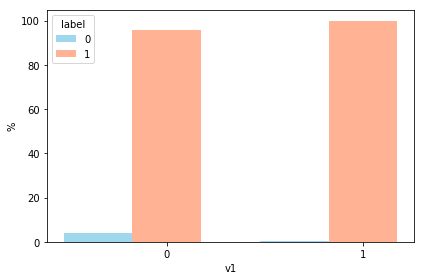

v2_label     0     1
      0  37.4   9.1
      1  62.6  90.9
4.952643987075855e-09
Null hipothesis rejected



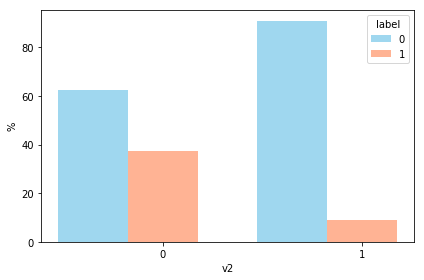

v3_label     0     1
      0  94.6  74.1
      1   5.4  25.9
1.1892293231417302e-19
Null hipothesis rejected



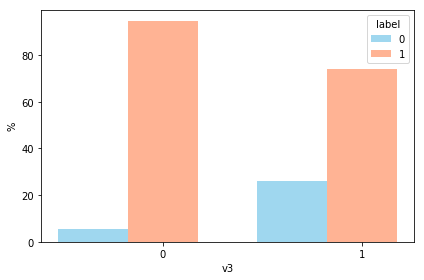

v4_label     0     1
      0  96.1  91.5
      1   3.9   8.5
0.01749694857905105
Null hipothesis rejected



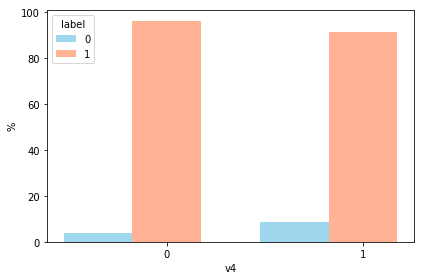

v5_label     0     1
      0  97.1  88.4
      1   2.9  11.6
2.1654299242101866e-07
Null hipothesis rejected



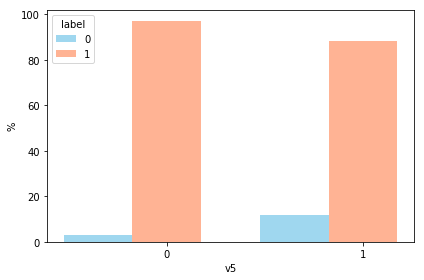

v6_label     0     1
      0  99.7  98.0
      1   0.3   2.0
0.0018808591226143496
Null hipothesis rejected



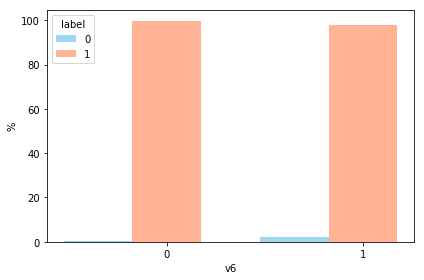

v7_label     0     1
      0  99.8  99.1
      1   0.2   0.9
0.11715789728361597
Alternative hipothesis rejected



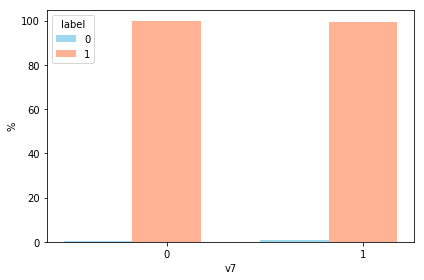

v8_label     0     1
      0  97.8  89.7
      1   2.2  10.3
3.349721281813157e-08
Null hipothesis rejected



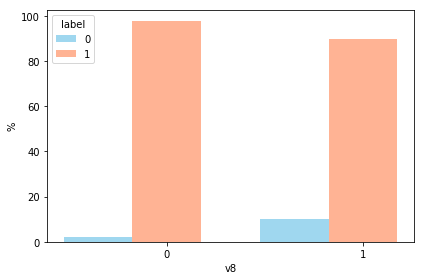

v9_label     0     1
      0  98.9  94.7
      1   1.1   5.3
5.655280557148193e-05
Null hipothesis rejected



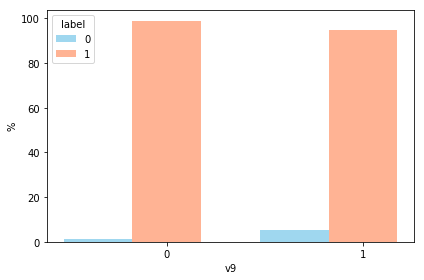

v10_label     0     1
       0  94.0  66.0
       1   6.0  34.0
4.3887927037326947e-32
Null hipothesis rejected



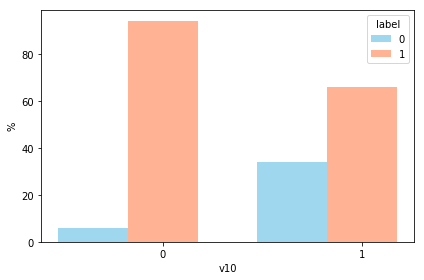

v11_label     0     1
       0  96.9  99.8
       1   3.1   0.2
0.09428231487354535
Alternative hipothesis rejected



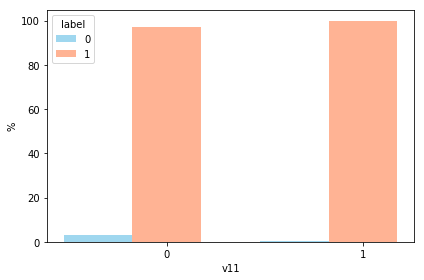

v12_label     0     1
       0  99.8  94.9
       1   0.2   5.1
5.464094318671064e-28
Null hipothesis rejected



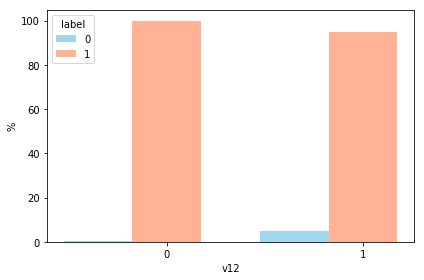

v13_label     0     1
       0  99.1  90.8
       1   0.9   9.2
1.5142670446286379e-18
Null hipothesis rejected



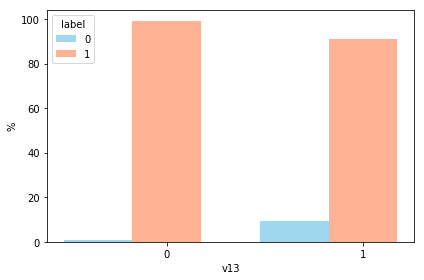

v14_label     0     1
       0  98.5  96.2
       1   1.5   3.8
0.058466048453622105
Alternative hipothesis rejected



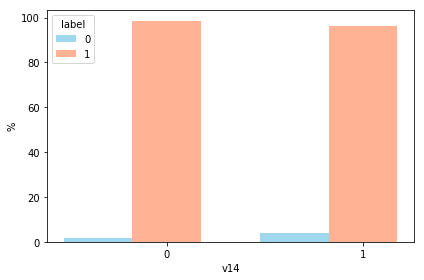

v15_label     0     1
       0  99.4  97.9
       1   0.6   2.1
0.05209747534082453
Alternative hipothesis rejected



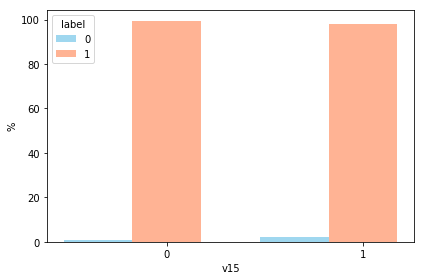

v16_label     0     1
       0  45.6  35.0
       1  54.4  65.0
0.033315812219099794
Null hipothesis rejected



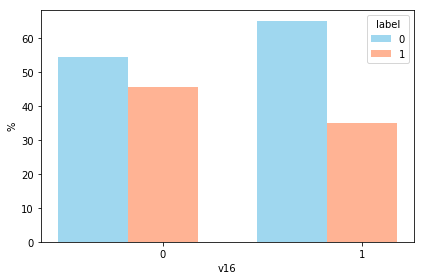

v17_label     0     1
       0  98.2  88.0
       1   1.8  12.0
1.693447236915232e-14
Null hipothesis rejected



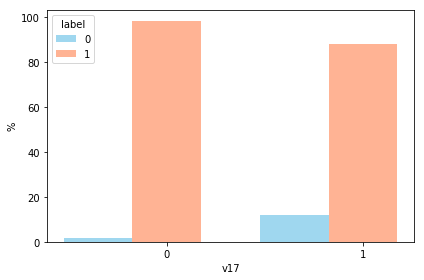

v18_label     0     1
       0  87.2  72.5
       1  12.8  27.5
1.082436461981308e-05
Null hipothesis rejected



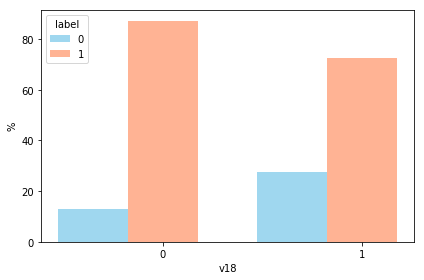

v19_label     0     1
       0  97.3  87.3
       1   2.7  12.7
6.843412562947188e-10
Null hipothesis rejected



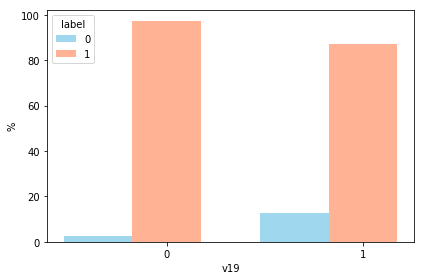

v20_label     0     1
       0   2.0   1.0
       1  98.0  99.0
0.47505052405395287
Alternative hipothesis rejected



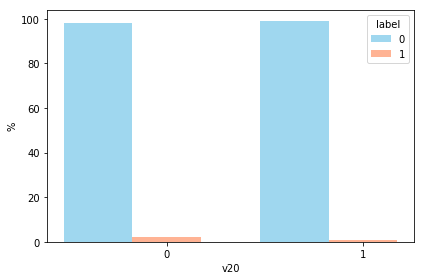

v21_label     0     1
       0  17.4   4.8
       1  82.6  95.2
0.0008887051288674177
Null hipothesis rejected



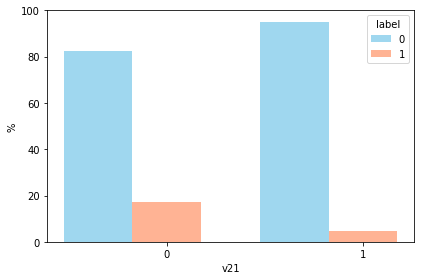

v22_label     0     1
       0  14.4   5.6
       1  85.6  94.4
0.012193935846909918
Null hipothesis rejected



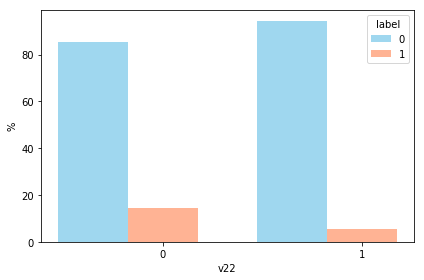

v23_label     0     1
       0   5.7   0.6
       1  94.3  99.4
0.027823351596387432
Null hipothesis rejected



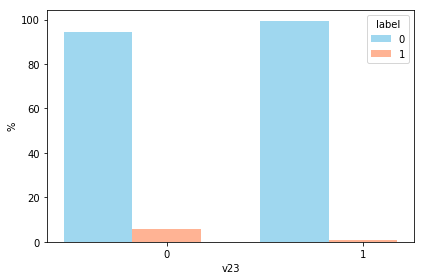

v24_label     0     1
       0  11.3   1.4
       1  88.7  98.6
0.0017657276052232076
Null hipothesis rejected



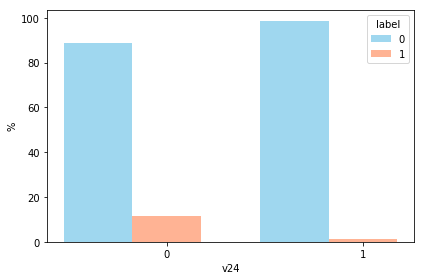

v25_label     0     1
       0  65.5  70.8
       1  34.5  29.2
0.2648825423866715
Alternative hipothesis rejected



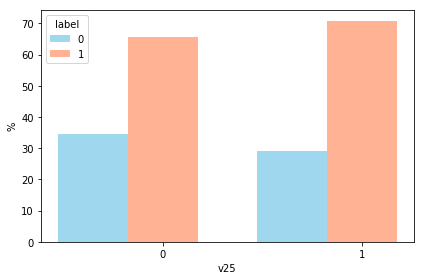

v26_label     0     1
       0   1.9   1.2
       1  98.1  98.8
0.6081418475176922
Alternative hipothesis rejected



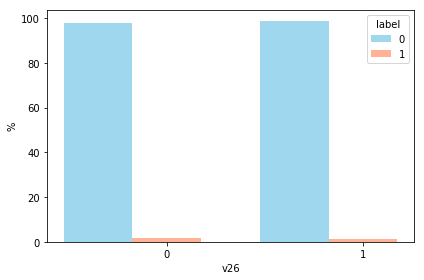

v27_label     0     1
       0  55.9  48.4
       1  44.1  51.6
0.13090229034952294
Alternative hipothesis rejected



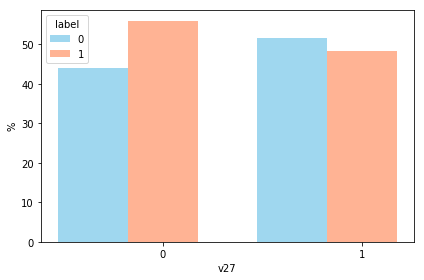

v60_label     0     1
       0  51.9  55.2
       1  48.1  44.8
0.5089477499247996
Alternative hipothesis rejected



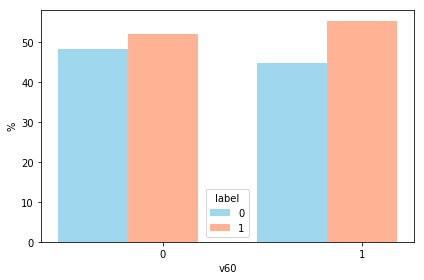

v61_label     0     1
       0  86.5  65.8
       1  13.5  34.2
1.3822955992358478e-09
Null hipothesis rejected



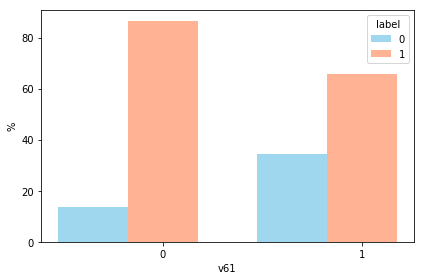

v62_label     0     1
       0  99.3  99.6
       1   0.7   0.4
0.7189741173299349
Alternative hipothesis rejected



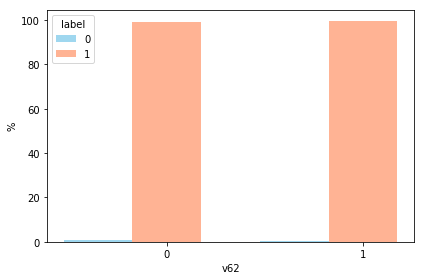

v63_label     0     1
       0  99.4  99.6
       1   0.6   0.4
0.795652994592478
Alternative hipothesis rejected



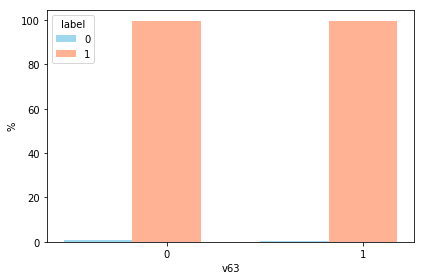

v64_label     0     1
       0  98.8  99.1
       1   1.2   0.9
0.7829172353091407
Alternative hipothesis rejected



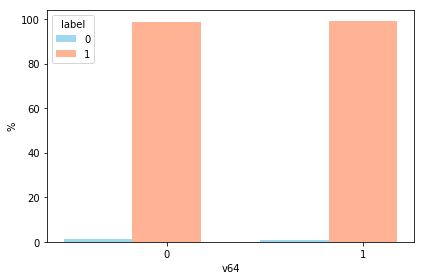

v65_label     0     1
       0  99.4  99.6
       1   0.6   0.4
0.795652994592478
Alternative hipothesis rejected



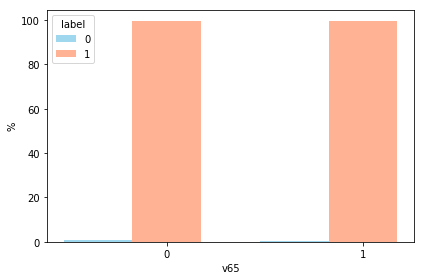

v66_label     0     1
       0  99.0  99.1
       1   1.0   0.9
0.9199443808170075
Alternative hipothesis rejected



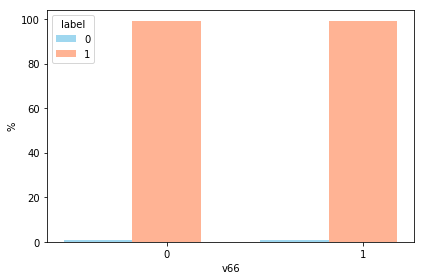

v67_label     0     1
       0  93.8  95.5
       1   6.2   4.5
0.4808480778436822
Alternative hipothesis rejected



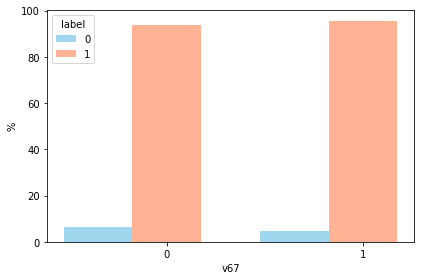

v68_label     0     1
       0  96.1  97.2
       1   3.9   2.8
0.569901429100659
Alternative hipothesis rejected



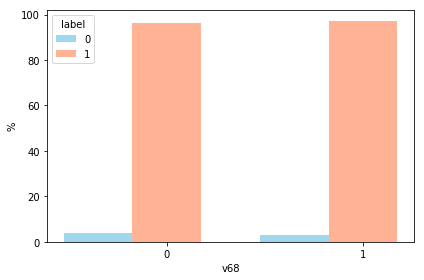

v69_label     0     1
       0  96.7  90.2
       1   3.3   9.8
0.00027404542316741126
Null hipothesis rejected



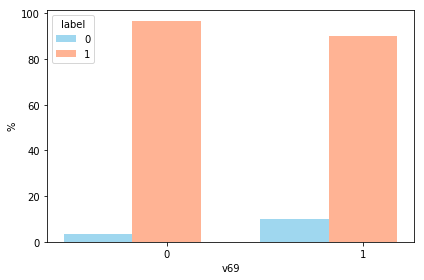

v70_label     0     1
       0  98.2  98.1
       1   1.8   1.9
0.9400431615811221
Alternative hipothesis rejected



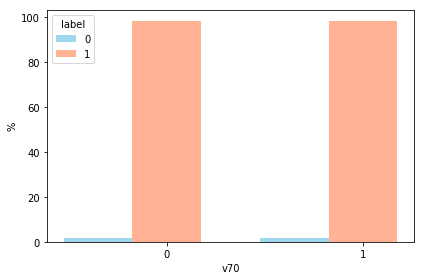

v71_label     0     1
       0  96.6  97.0
       1   3.4   3.0
0.8253143035340773
Alternative hipothesis rejected



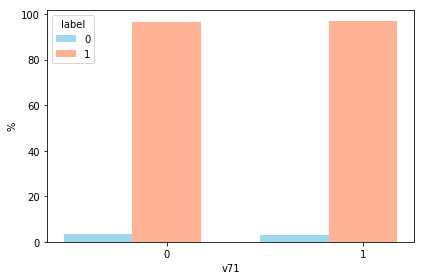

v72_label     0     1
       0  97.0  98.1
       1   3.0   1.9
0.5190364381640884
Alternative hipothesis rejected



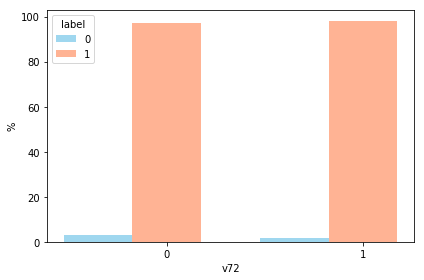

v73_label     0     1
       0  97.1  97.4
       1   2.9   2.6
0.8581124838457889
Alternative hipothesis rejected



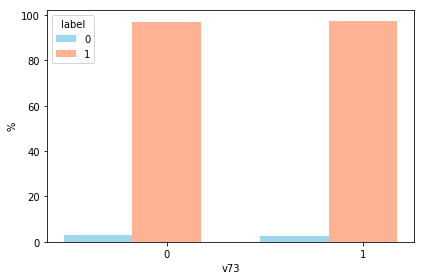

v74_label     0     1
       0  98.1  98.2
       1   1.9   1.8
0.941609720019773
Alternative hipothesis rejected



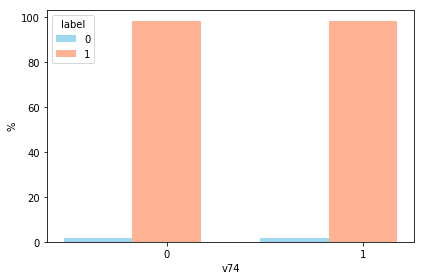

v75_label     0     1
       0  90.3  90.7
       1   9.7   9.3
0.8924897849257498
Alternative hipothesis rejected



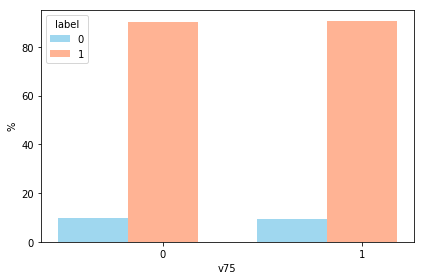

v76_label     0     1
       0  97.2  97.9
       1   2.8   2.1
0.6713378773253416
Alternative hipothesis rejected



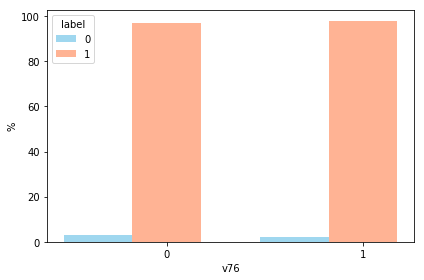

v77_label     0     1
       0  97.7  98.3
       1   2.3   1.7
0.688966479139549
Alternative hipothesis rejected



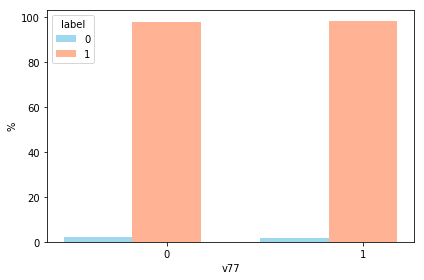

v78_label     0     1
       0  94.7  94.2
       1   5.3   5.8
0.8233946944760359
Alternative hipothesis rejected



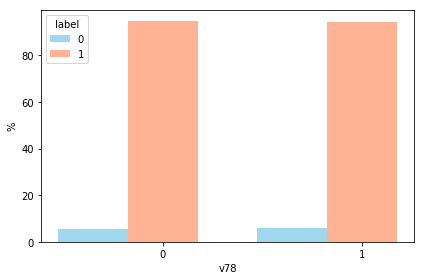

v79_label     0     1
       0  96.7  97.3
       1   3.3   2.7
0.736963168142443
Alternative hipothesis rejected



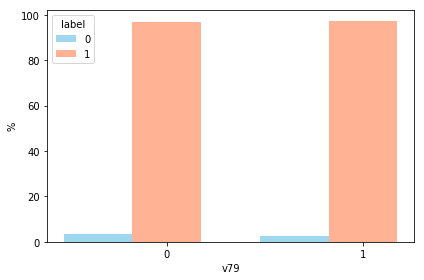

v80_label     0     1
       0  98.4  98.9
       1   1.6   1.1
0.6902723846023666
Alternative hipothesis rejected



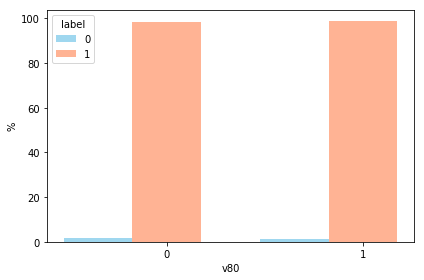

v81_label     0     1
       0  94.1  90.7
       1   5.9   9.3
0.14902817592490278
Alternative hipothesis rejected



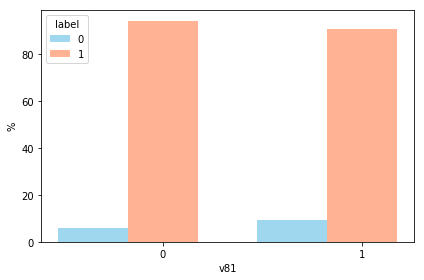

v82_label     0     1
       0  97.5  97.8
       1   2.5   2.2
0.8476217458063826
Alternative hipothesis rejected



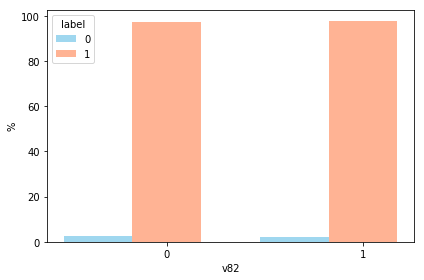

v83_label     0     1
       0  95.6  93.7
       1   4.4   6.3
0.35423839877493757
Alternative hipothesis rejected



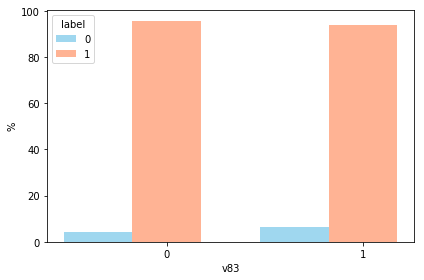

v84_label     0     1
       0  98.9  99.1
       1   1.1   0.9
0.8479379917118228
Alternative hipothesis rejected



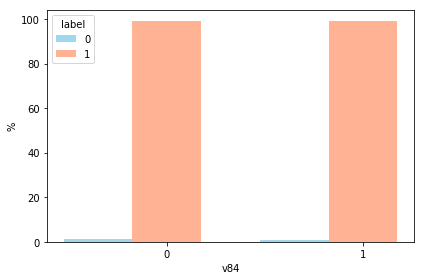

v85_label     0     1
       0  99.5  99.4
       1   0.5   0.6
0.8872567514079835
Alternative hipothesis rejected



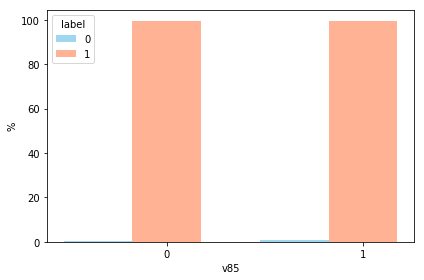

v86_label     0     1
       0  95.4  95.5
       1   4.6   4.5
0.9619265665586131
Alternative hipothesis rejected



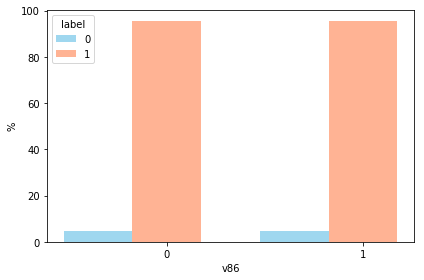

v87_label     0     1
       0  75.8  79.4
       1  24.2  20.6
0.4006036996988458
Alternative hipothesis rejected



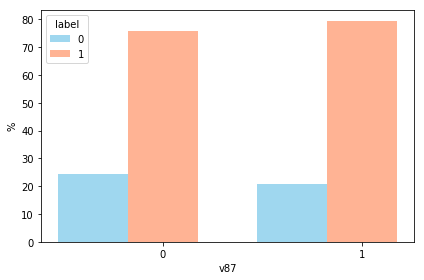

v88_label     0     1
       0  99.1  99.0
       1   0.9   1.0
0.9156721490126649
Alternative hipothesis rejected



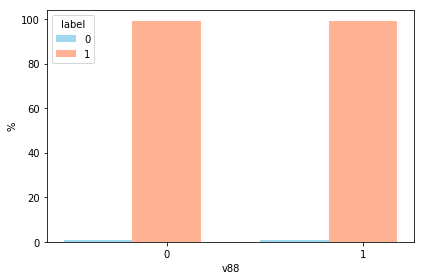

v89_label     0     1
       0  98.9  99.1
       1   1.1   0.9
0.8479379917118228
Alternative hipothesis rejected



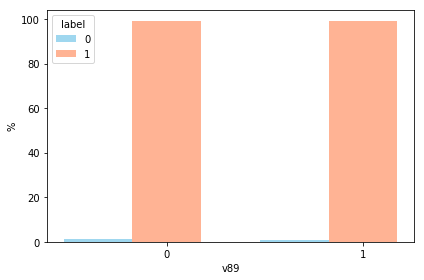

v90_label     0     1
       0  99.5  99.8
       1   0.5   0.2
0.6705970577577671
Alternative hipothesis rejected



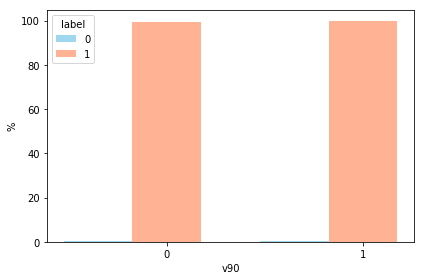

v91_label     0     1
       0  99.8  99.9
       1   0.2   0.1
0.8228890092824235
Alternative hipothesis rejected



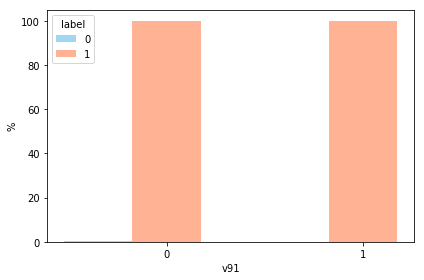

v92_label     0     1
       0  98.8  98.7
       1   1.2   1.3
0.9268253259755083
Alternative hipothesis rejected



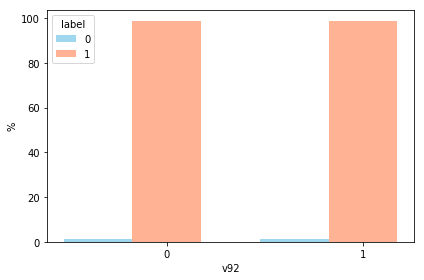

v93_label     0     1
       0  98.2  97.8
       1   1.8   2.2
0.7635193811932033
Alternative hipothesis rejected



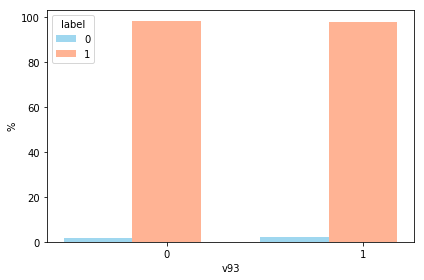

v94_label     0     1
       0  98.8  98.1
       1   1.2   1.9
0.5203028999678316
Alternative hipothesis rejected



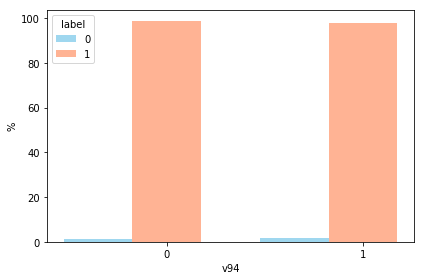

v95_label      0      1
       0  100.0  100.0
       1    0.0    0.0
nan
Alternative hipothesis rejected



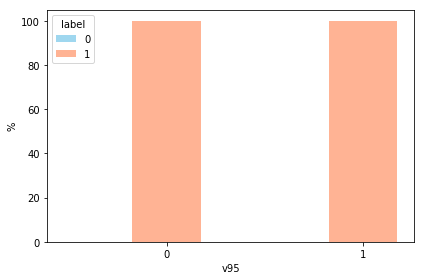

v96_label     0     1
       0  99.2  99.4
       1   0.8   0.6
0.8223631105053809
Alternative hipothesis rejected



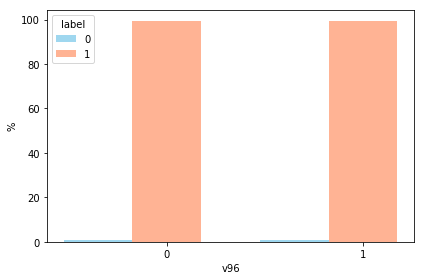

v97_label      0      1
       0  100.0  100.0
       1    0.0    0.0
nan
Alternative hipothesis rejected



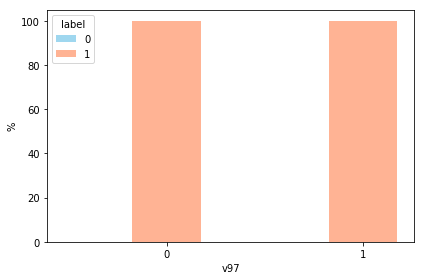

v98_label     0     1
       0  96.1  95.6
       1   3.9   4.4
0.796197599294695
Alternative hipothesis rejected



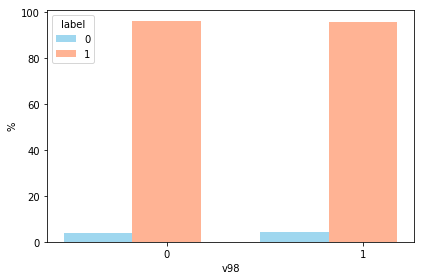

v99_label     0      1
       0  99.8  100.0
       1   0.2    0.0
0.6543975248481576
Alternative hipothesis rejected



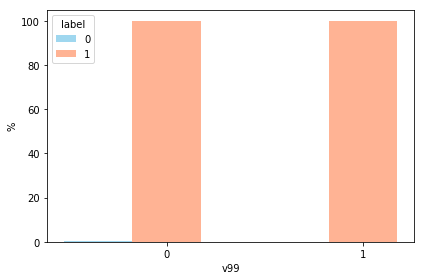

v100_label     0     1
        0  99.8  99.9
        1   0.2   0.1
0.8228890092824235
Alternative hipothesis rejected



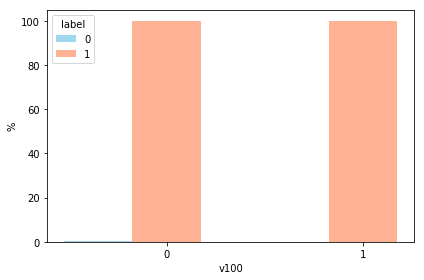

v101_label     0      1
        0  99.9  100.0
        1   0.1    0.0
0.751709543078071
Alternative hipothesis rejected



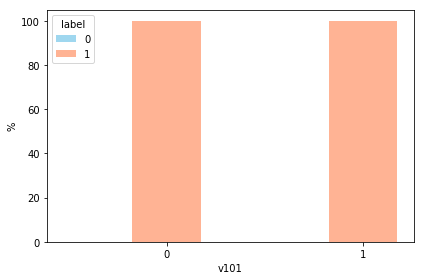

v102_label     0     1
        0  99.7  99.9
        1   0.3   0.1
0.7145909389149455
Alternative hipothesis rejected



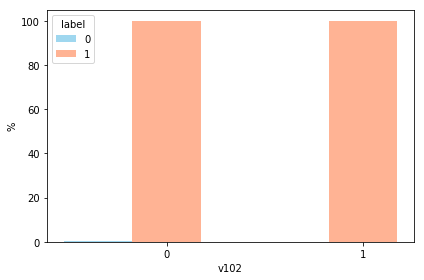

v103_label     0     1
        0  97.6  97.9
        1   2.4   2.1
0.8445979244628211
Alternative hipothesis rejected



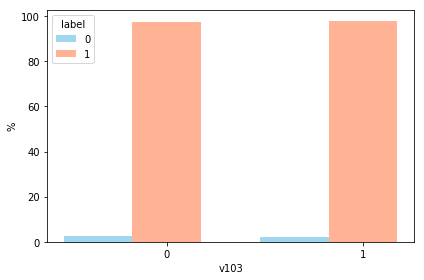

v104_label     0     1
        0  99.4  99.8
        1   0.6   0.2
0.6044903788033886
Alternative hipothesis rejected



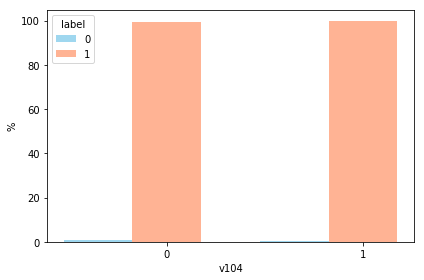

v105_label     0     1
        0  99.1  99.4
        1   0.9   0.6
0.7507425003039904
Alternative hipothesis rejected



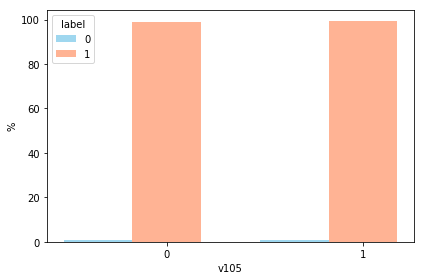

v106_label     0     1
        0  99.7  99.9
        1   0.3   0.1
0.7145909389149455
Alternative hipothesis rejected



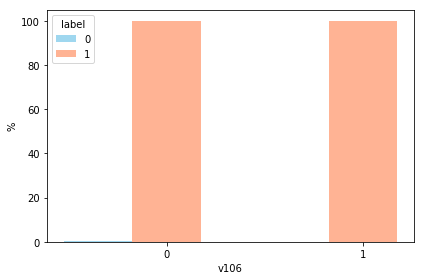

v107_label     0     1
        0  98.9  98.8
        1   1.1   1.2
0.9236198265935888
Alternative hipothesis rejected



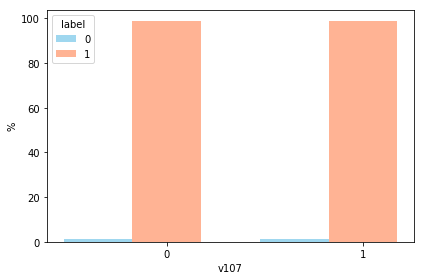

v108_label     0     1
        0  99.8  99.8
        1   0.2   0.2
1.0
Alternative hipothesis rejected



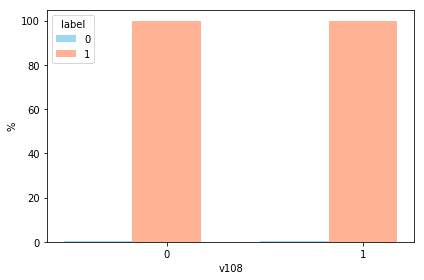

v109_label     0     1
        0  99.5  99.6
        1   0.5   0.4
0.8872567514079835
Alternative hipothesis rejected



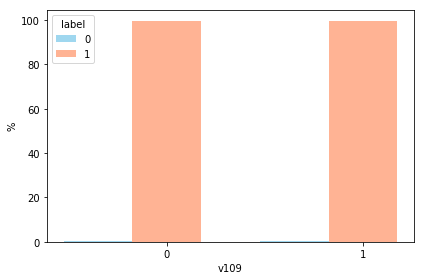

v110_label     0     1
        0  98.9  99.3
        1   1.1   0.7
0.7013489820972
Alternative hipothesis rejected



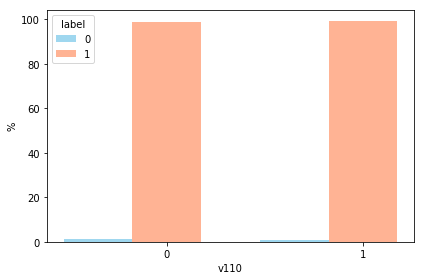

v111_label     0     1
        0  98.4  99.0
        1   1.6   1.0
0.6325202921884682
Alternative hipothesis rejected



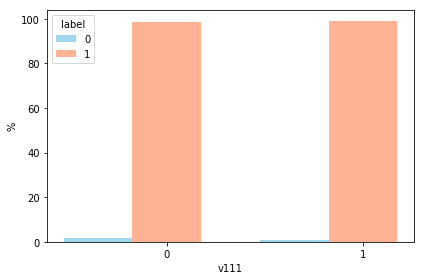

v112_label     0     1
        0  99.7  99.8
        1   0.3   0.2
0.8549167632127839
Alternative hipothesis rejected



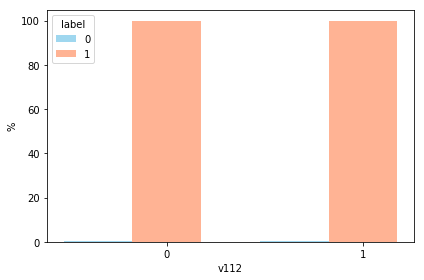

v113_label     0     1
        0  98.8  98.7
        1   1.2   1.3
0.9268253259755083
Alternative hipothesis rejected



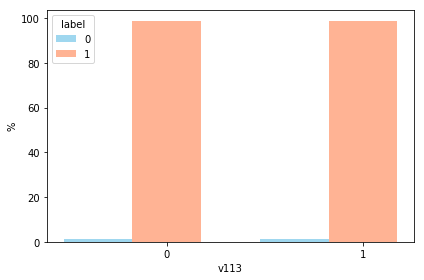

v114_label     0     1
        0  99.2  99.6
        1   0.8   0.4
0.6534220947553175
Alternative hipothesis rejected



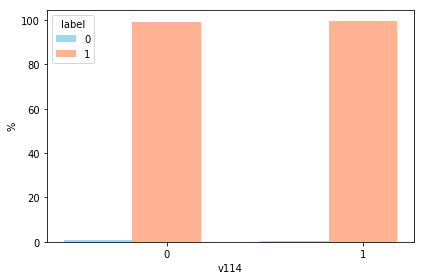

v115_label     0     1
        0  97.7  96.7
        1   2.3   3.3
0.5047103602032054
Alternative hipothesis rejected



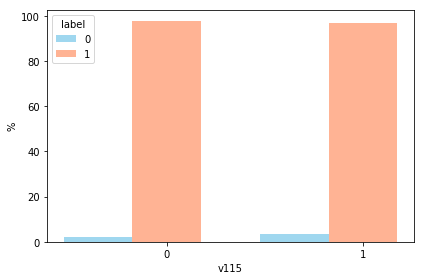

v116_label      0      1
        0  100.0  100.0
        1    0.0    0.0
nan
Alternative hipothesis rejected



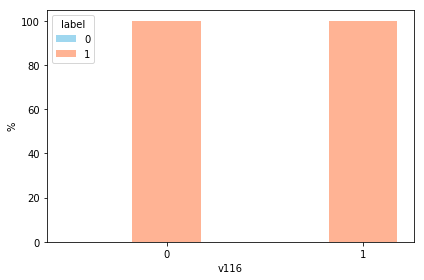

v117_label     0     1
        0  97.9  97.7
        1   2.1   2.3
0.8890665287704409
Alternative hipothesis rejected



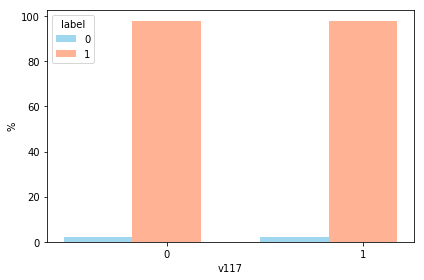

v118_label     0     1
        0  99.1  99.2
        1   0.9   0.8
0.9156721490126648
Alternative hipothesis rejected



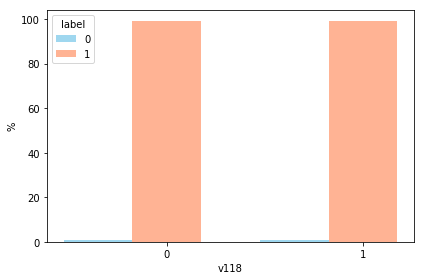

v119_label     0     1
        0  99.8  99.9
        1   0.2   0.1
0.8228890092824235
Alternative hipothesis rejected



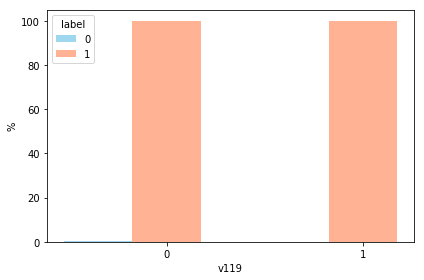

v120_label     0     1
        0  99.1  99.2
        1   0.9   0.8
0.9156721490126648
Alternative hipothesis rejected



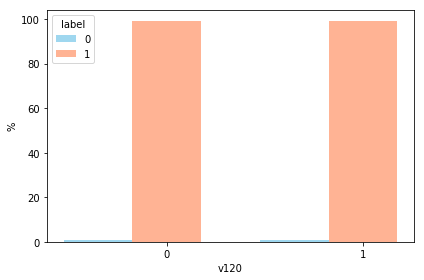

v121_label     0      1
        0  99.8  100.0
        1   0.2    0.0
0.6543975248481576
Alternative hipothesis rejected



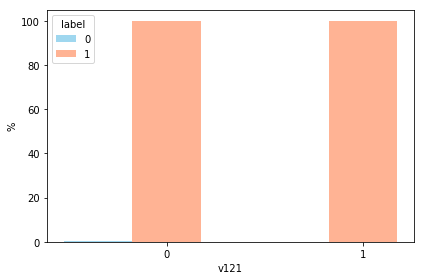

v122_label     0     1
        0  99.7  99.9
        1   0.3   0.1
0.7145909389149455
Alternative hipothesis rejected



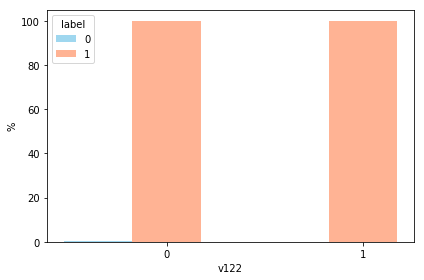

v123_label     0      1
        0  99.9  100.0
        1   0.1    0.0
0.751709543078071
Alternative hipothesis rejected



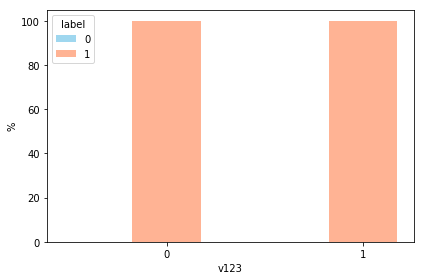

v124_label     0     1
        0  99.0  99.2
        1   1.0   0.8
0.8406926603054861
Alternative hipothesis rejected



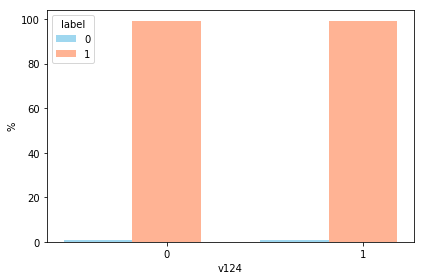

v125_label     0     1
        0  99.1  99.2
        1   0.9   0.8
0.9156721490126648
Alternative hipothesis rejected



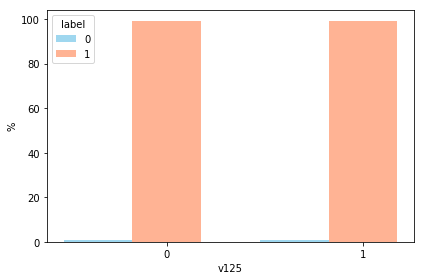

v126_label     0     1
        0  99.7  99.9
        1   0.3   0.1
0.7145909389149455
Alternative hipothesis rejected



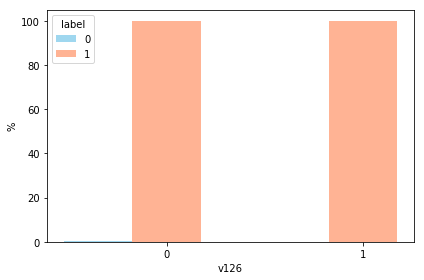

v127_label     0     1
        0  99.8  99.9
        1   0.2   0.1
0.8228890092824235
Alternative hipothesis rejected



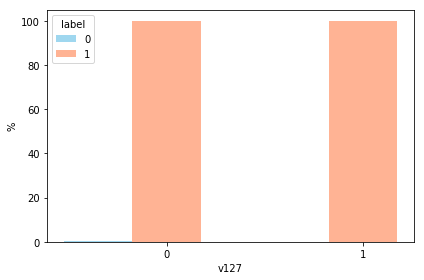

v128_label     0     1
        0  99.7  99.9
        1   0.3   0.1
0.7145909389149455
Alternative hipothesis rejected



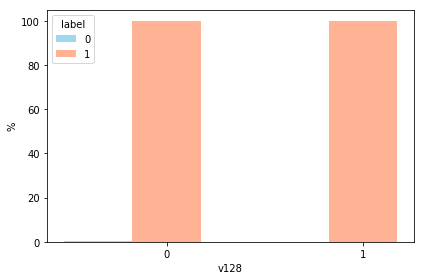

v129_label     0     1
        0  99.4  99.8
        1   0.6   0.2
0.6044903788033886
Alternative hipothesis rejected



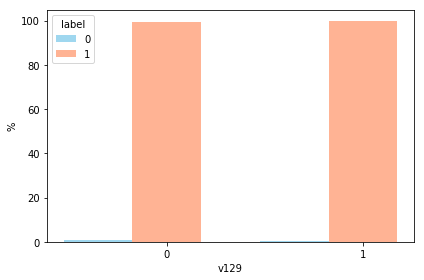

v130_label     0     1
        0  99.3  99.1
        1   0.7   0.9
0.8104180140900636
Alternative hipothesis rejected



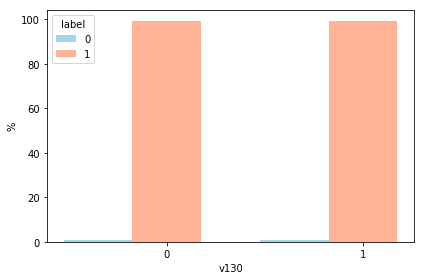

v131_label     0     1
        0  99.3  99.4
        1   0.7   0.6
0.9045279843359131
Alternative hipothesis rejected



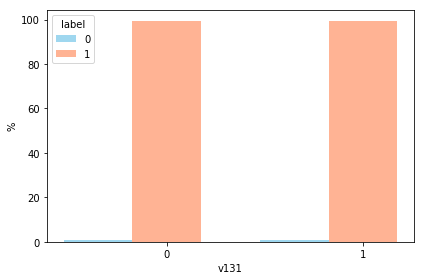

v132_label     0     1
        0  99.1  99.1
        1   0.9   0.9
1.0
Alternative hipothesis rejected



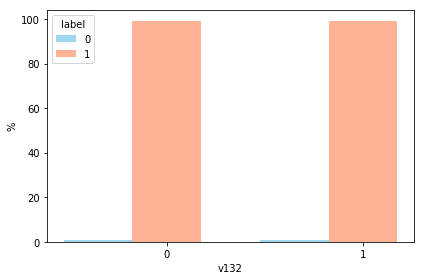

v133_label     0     1
        0  99.8  99.7
        1   0.2   0.3
0.8228890092824236
Alternative hipothesis rejected



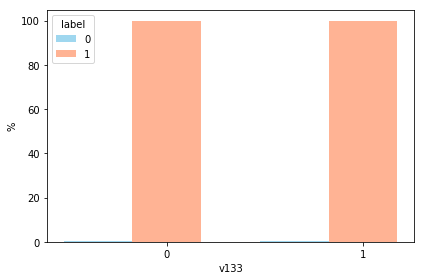

v134_label     0      1
        0  99.9  100.0
        1   0.1    0.0
0.751709543078071
Alternative hipothesis rejected



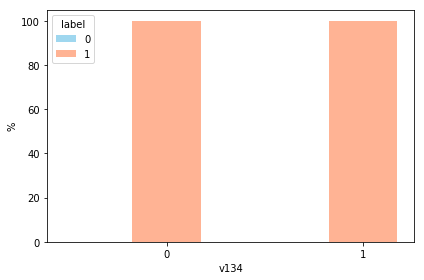

v135_label     0     1
        0  99.5  99.8
        1   0.5   0.2
0.6705970577577671
Alternative hipothesis rejected



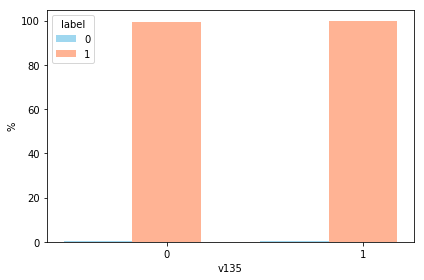

v136_label     0     1
        0  99.9  99.9
        1   0.1   0.1
1.0
Alternative hipothesis rejected



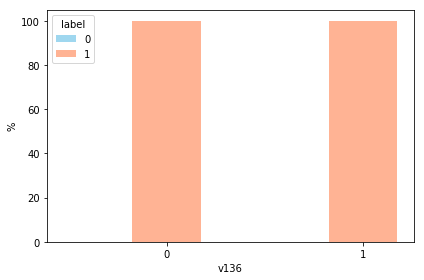

v137_label     0     1
        0  99.6  99.6
        1   0.4   0.4
1.0
Alternative hipothesis rejected



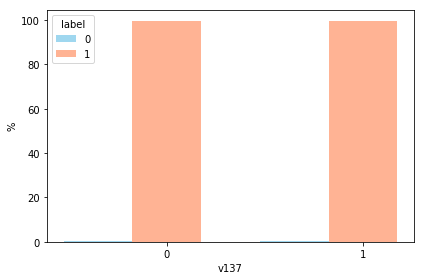

v138_label     0     1
        0  99.2  99.6
        1   0.8   0.4
0.6534220947553175
Alternative hipothesis rejected



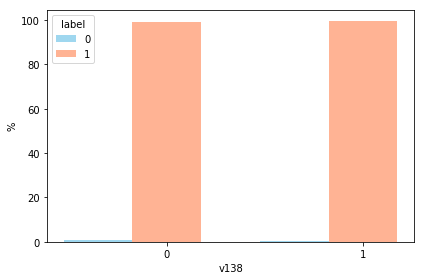

v139_label     0     1
        0  99.8  99.8
        1   0.2   0.2
1.0
Alternative hipothesis rejected



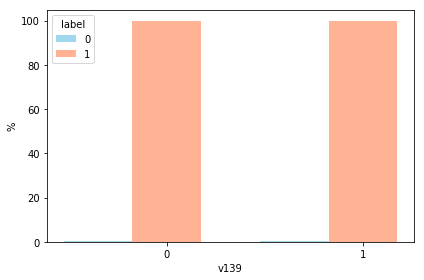

v140_label     0      1
        0  99.9  100.0
        1   0.1    0.0
0.751709543078071
Alternative hipothesis rejected



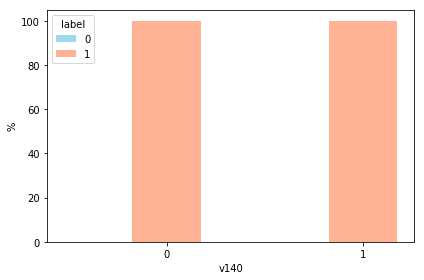

v141_label     0     1
        0  99.9  99.9
        1   0.1   0.1
1.0
Alternative hipothesis rejected



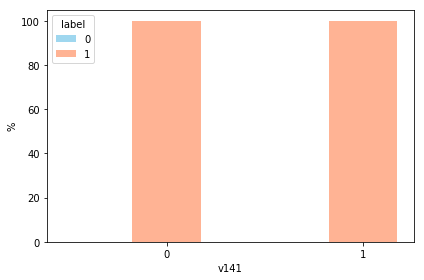

v142_label     0     1
        0  99.5  99.8
        1   0.5   0.2
0.6705970577577671
Alternative hipothesis rejected



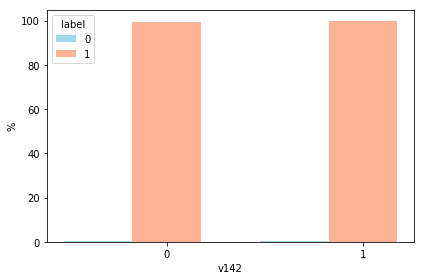

v143_label     0     1
        0  99.6  99.7
        1   0.4   0.3
0.8741171384299223
Alternative hipothesis rejected



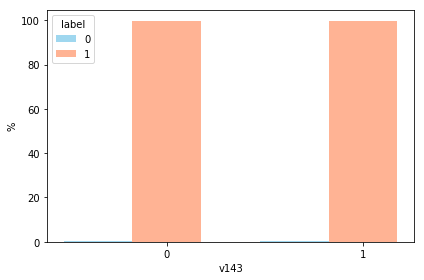

v144_label     0     1
        0  99.2  99.2
        1   0.8   0.8
1.0
Alternative hipothesis rejected



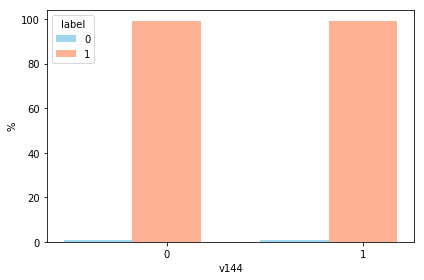

v145_label     0     1
        0  99.9  99.9
        1   0.1   0.1
1.0
Alternative hipothesis rejected



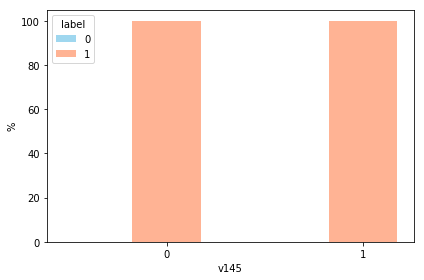

v146_label     0     1
        0  99.8  99.8
        1   0.2   0.2
1.0
Alternative hipothesis rejected



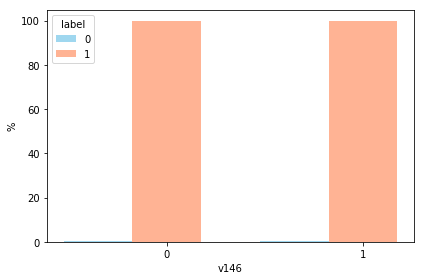

v147_label     0      1
        0  99.9  100.0
        1   0.1    0.0
0.751709543078071
Alternative hipothesis rejected



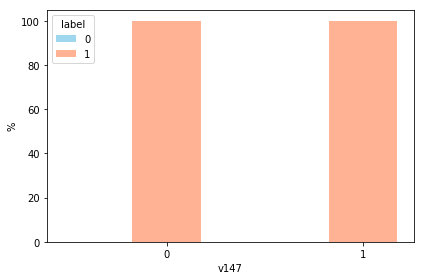

v148_label     0     1
        0  99.7  99.9
        1   0.3   0.1
0.7145909389149455
Alternative hipothesis rejected



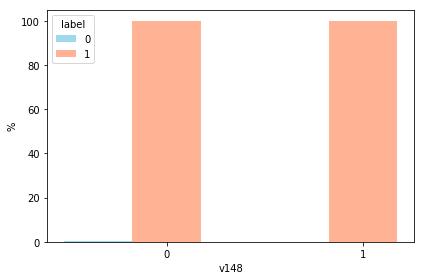

v149_label     0     1
        0  98.2  98.2
        1   1.8   1.8
1.0
Alternative hipothesis rejected



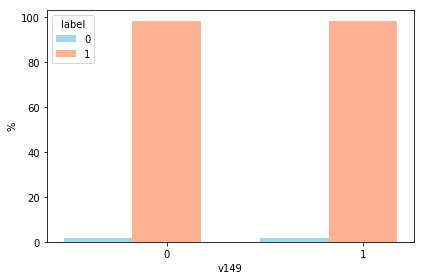

v150_label     0     1
        0  99.7  99.5
        1   0.3   0.5
0.7145909389149455
Alternative hipothesis rejected



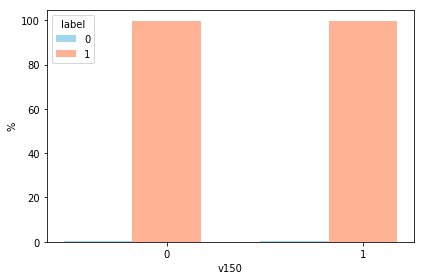

v151_label     0      1
        0  99.9  100.0
        1   0.1    0.0
0.751709543078071
Alternative hipothesis rejected



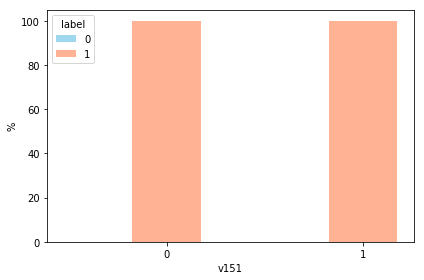

v152_label      0      1
        0  100.0  100.0
        1    0.0    0.0
nan
Alternative hipothesis rejected



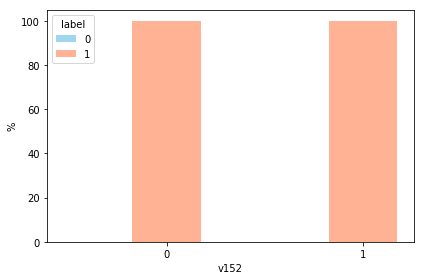

v153_label     0     1
        0  99.4  99.0
        1   0.6   1.0
0.6044903788033884
Alternative hipothesis rejected



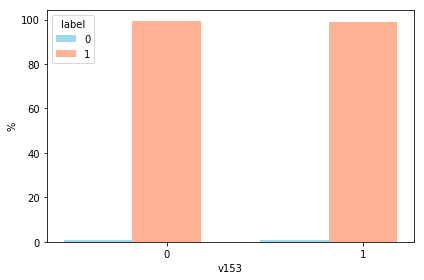

v154_label     0      1
        0  99.8  100.0
        1   0.2    0.0
0.6543975248481576
Alternative hipothesis rejected



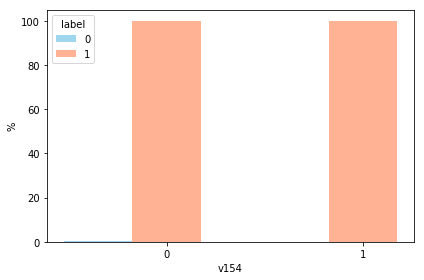

v155_label     0     1
        0  99.8  99.9
        1   0.2   0.1
0.8228890092824235
Alternative hipothesis rejected



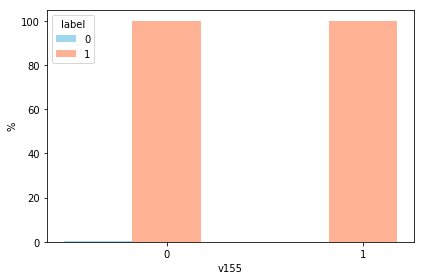

v156_label      0      1
        0  100.0  100.0
        1    0.0    0.0
nan
Alternative hipothesis rejected



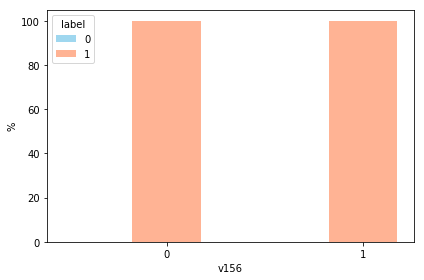

v157_label     0     1
        0  99.1  99.4
        1   0.9   0.6
0.7507425003039904
Alternative hipothesis rejected



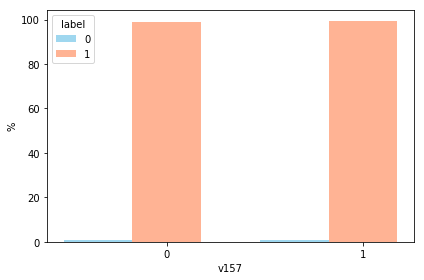

v158_label     0     1
        0  97.9  97.5
        1   2.1   2.5
0.7802671103826584
Alternative hipothesis rejected



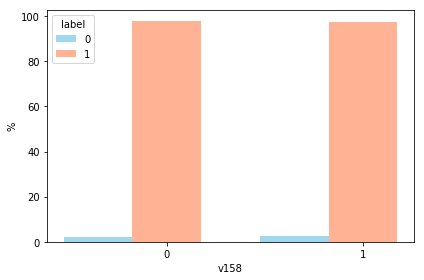

v159_label     0     1
        0  99.7  99.8
        1   0.3   0.2
0.8549167632127839
Alternative hipothesis rejected



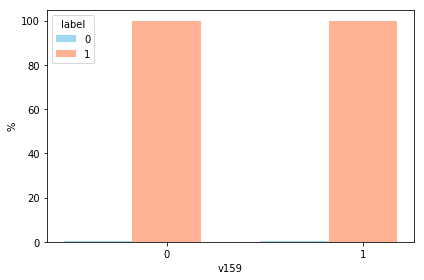

v160_label     0     1
        0  99.2  99.5
        1   0.8   0.5
0.7362978731419881
Alternative hipothesis rejected



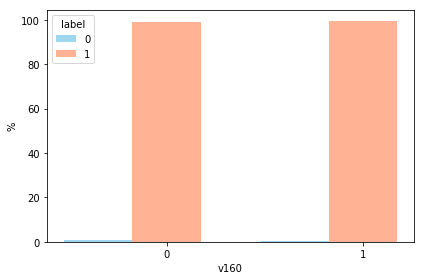

v161_label     0     1
        0  99.4  99.6
        1   0.6   0.4
0.795652994592478
Alternative hipothesis rejected



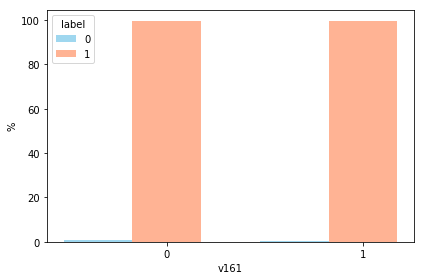

v162_label     0      1
        0  99.9  100.0
        1   0.1    0.0
0.751709543078071
Alternative hipothesis rejected



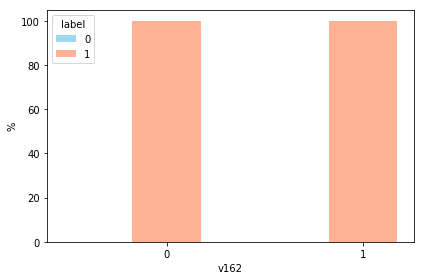

v163_label     0     1
        0  99.8  99.9
        1   0.2   0.1
0.8228890092824235
Alternative hipothesis rejected



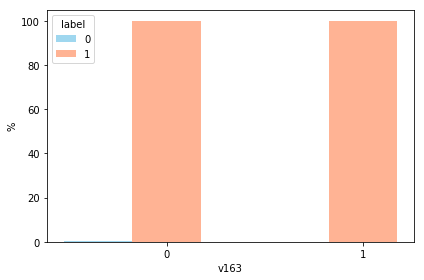

v164_label     0     1
        0  99.8  99.8
        1   0.2   0.2
1.0
Alternative hipothesis rejected



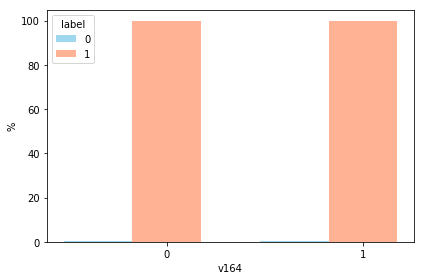

v165_label     0     1
        0  99.6  99.7
        1   0.4   0.3
0.8741171384299223
Alternative hipothesis rejected



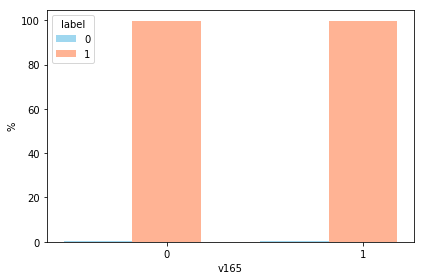

v166_label     0     1
        0  99.0  99.1
        1   1.0   0.9
0.9199443808170075
Alternative hipothesis rejected



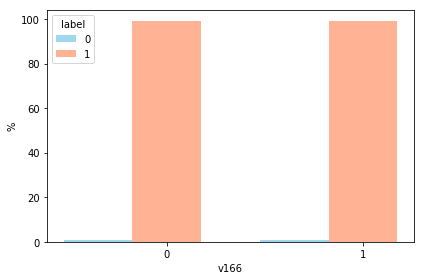

v167_label     0     1
        0  99.6  99.7
        1   0.4   0.3
0.8741171384299223
Alternative hipothesis rejected



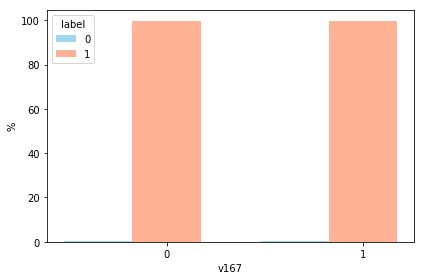

v168_label     0     1
        0  99.8  99.9
        1   0.2   0.1
0.8228890092824235
Alternative hipothesis rejected



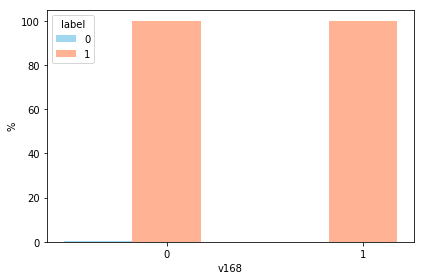

v169_label     0     1
        0  99.7  99.9
        1   0.3   0.1
0.7145909389149455
Alternative hipothesis rejected



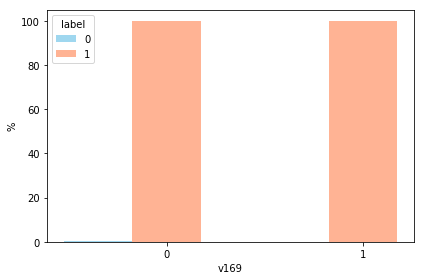

v170_label     0     1
        0  99.8  99.8
        1   0.2   0.2
1.0
Alternative hipothesis rejected



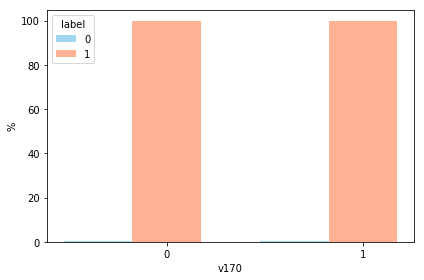

v171_label     0     1
        0  99.6  99.9
        1   0.4   0.1
0.6345780138397354
Alternative hipothesis rejected



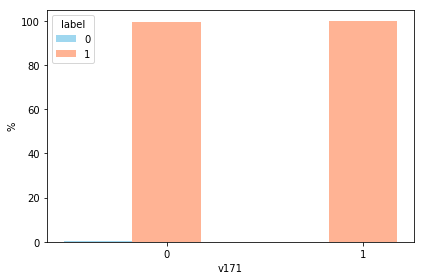

v172_label     0     1
        0  99.4  99.4
        1   0.6   0.6
1.0
Alternative hipothesis rejected



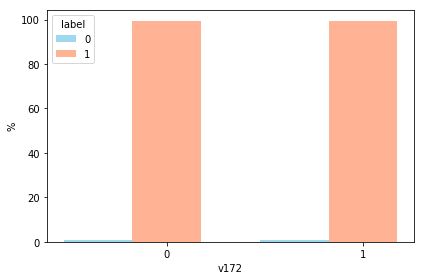

v173_label     0     1
        0  95.3  91.9
        1   4.7   8.1
0.10816181466543369
Alternative hipothesis rejected



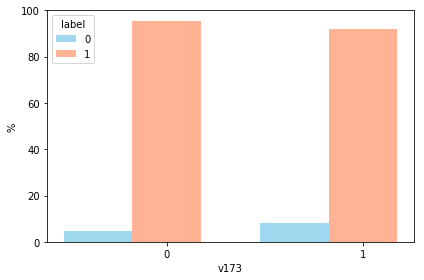

v174_label     0     1
        0  99.5  99.6
        1   0.5   0.4
0.8872567514079835
Alternative hipothesis rejected



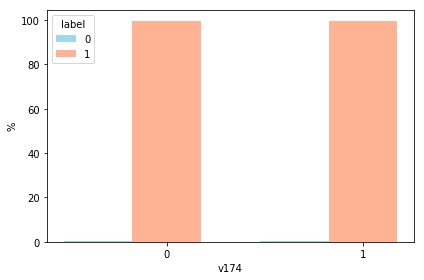

v175_label     0     1
        0  99.6  99.9
        1   0.4   0.1
0.6345780138397354
Alternative hipothesis rejected



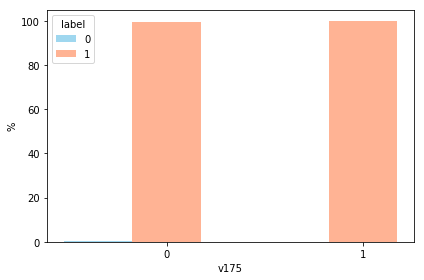

v176_label     0     1
        0  99.8  99.8
        1   0.2   0.2
1.0
Alternative hipothesis rejected



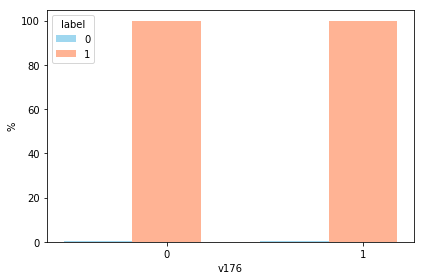

v177_label     0     1
        0  99.5  99.6
        1   0.5   0.4
0.8872567514079835
Alternative hipothesis rejected



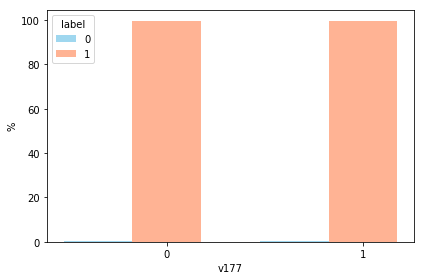

v178_label     0     1
        0  99.8  99.8
        1   0.2   0.2
1.0
Alternative hipothesis rejected



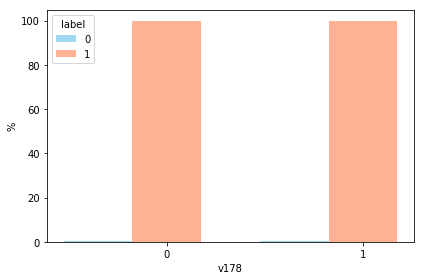

v179_label     0     1
        0  99.8  99.9
        1   0.2   0.1
0.8228890092824235
Alternative hipothesis rejected



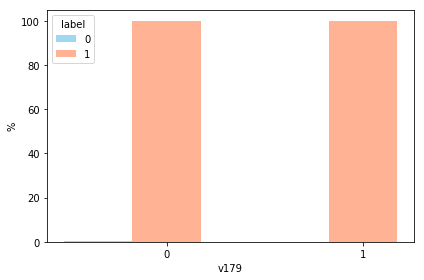

v180_label     0     1
        0  99.9  99.9
        1   0.1   0.1
1.0
Alternative hipothesis rejected



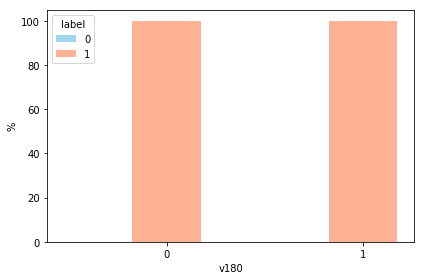

v181_label     0     1
        0  99.3  99.5
        1   0.7   0.5
0.8104180140900639
Alternative hipothesis rejected



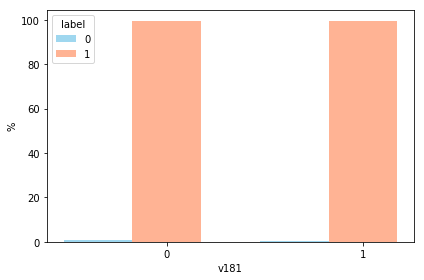

v182_label     0     1
        0  98.5  98.8
        1   1.5   1.2
0.8050575766323556
Alternative hipothesis rejected



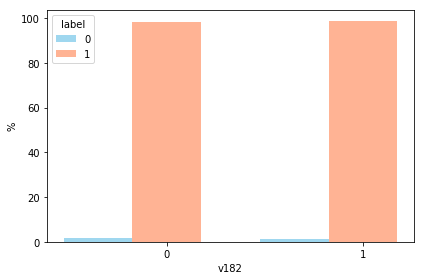

v183_label     0     1
        0  99.9  99.9
        1   0.1   0.1
1.0
Alternative hipothesis rejected



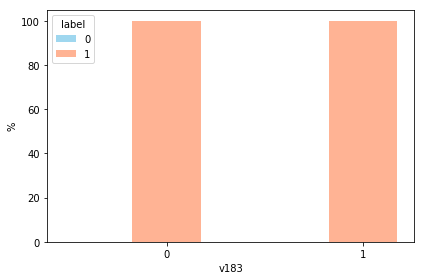

v184_label     0     1
        0  99.5  99.7
        1   0.5   0.3
0.7767533567940003
Alternative hipothesis rejected



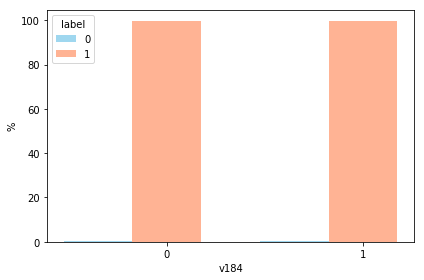

v185_label     0     1
        0  99.8  99.8
        1   0.2   0.2
1.0
Alternative hipothesis rejected



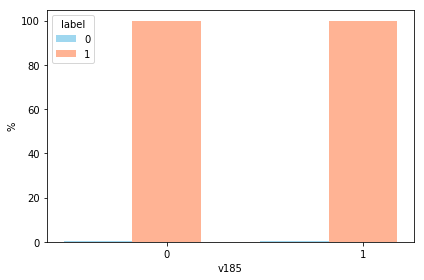

v186_label     0     1
        0  98.5  98.6
        1   1.5   1.4
0.9344327997001111
Alternative hipothesis rejected



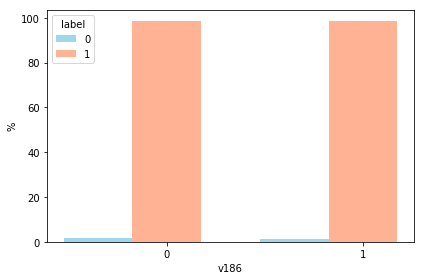

v187_label     0     1
        0  96.7  90.2
        1   3.3   9.8
0.00027404542316741126
Null hipothesis rejected



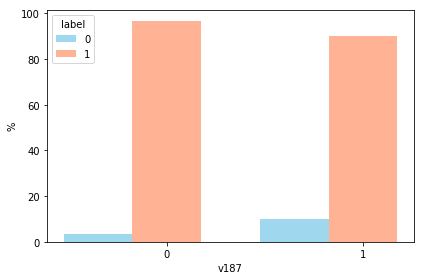

v188_label     0     1
        0  99.9  99.9
        1   0.1   0.1
1.0
Alternative hipothesis rejected



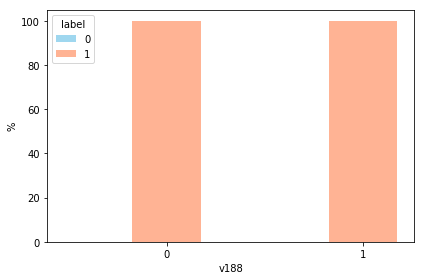

v189_label     0     1
        0  99.5  99.7
        1   0.5   0.3
0.7767533567940003
Alternative hipothesis rejected



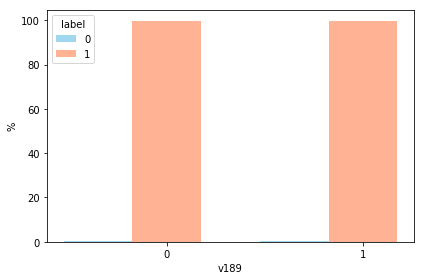

v190_label     0     1
        0  99.8  99.5
        1   0.2   0.5
0.5019070130547161
Alternative hipothesis rejected



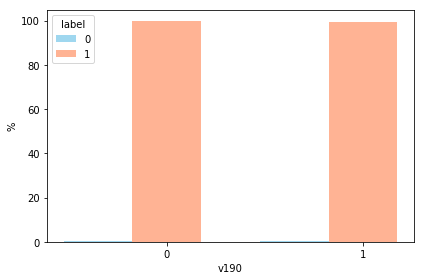

v191_label     0     1
        0  99.5  99.5
        1   0.5   0.5
1.0
Alternative hipothesis rejected



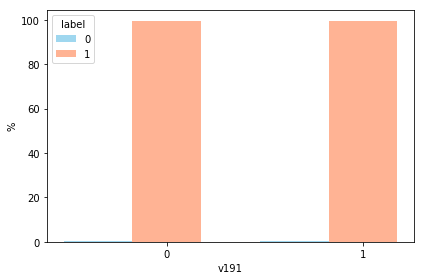

v192_label     0     1
        0  99.7  99.7
        1   0.3   0.3
1.0
Alternative hipothesis rejected



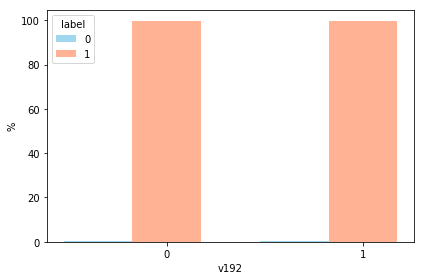

v193_label     0     1
        0  99.7  99.9
        1   0.3   0.1
0.7145909389149455
Alternative hipothesis rejected



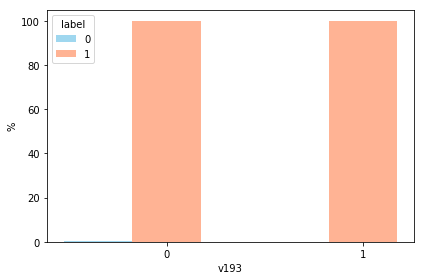

v194_label     0     1
        0  99.6  99.9
        1   0.4   0.1
0.6345780138397354
Alternative hipothesis rejected



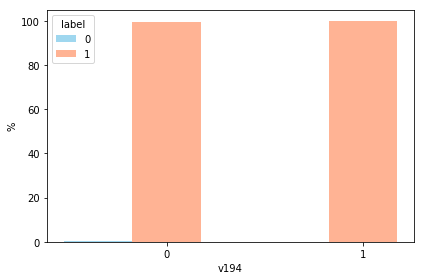

v195_label     0     1
        0  99.8  99.9
        1   0.2   0.1
0.8228890092824235
Alternative hipothesis rejected



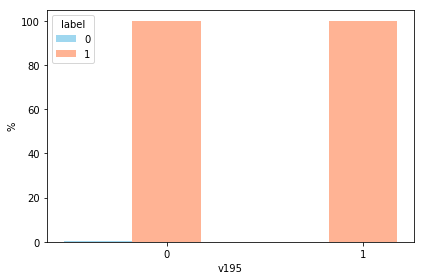

v196_label     0     1
        0  99.8  99.9
        1   0.2   0.1
0.8228890092824235
Alternative hipothesis rejected



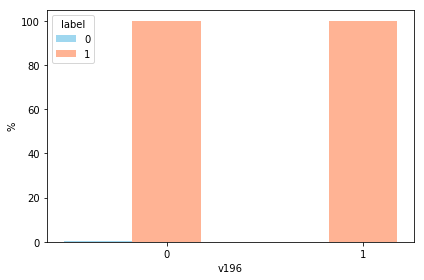

v197_label     0     1
        0  99.3  99.6
        1   0.7   0.4
0.7189741173299349
Alternative hipothesis rejected



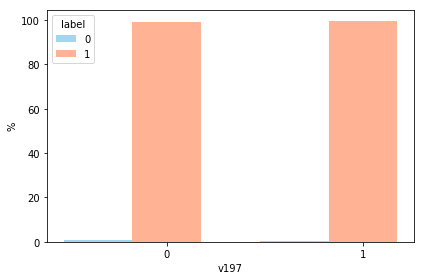

v198_label     0     1
        0  99.8  99.7
        1   0.2   0.3
0.8228890092824236
Alternative hipothesis rejected



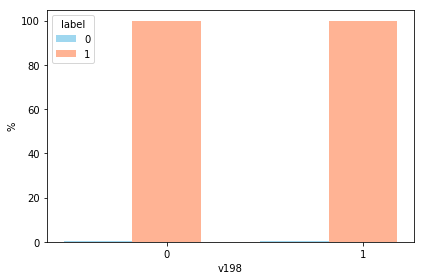

v199_label     0     1
        0  99.6  99.4
        1   0.4   0.6
0.7513482219227449
Alternative hipothesis rejected



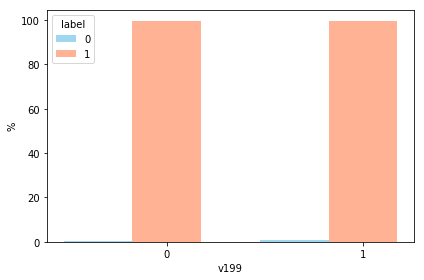

v200_label     0     1
        0  99.7  99.8
        1   0.3   0.2
0.8549167632127839
Alternative hipothesis rejected



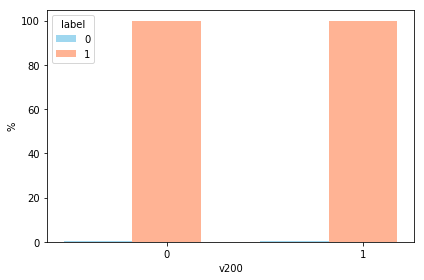

v201_label     0     1
        0  88.7  89.1
        1  11.3  10.9
0.8994586295575668
Alternative hipothesis rejected



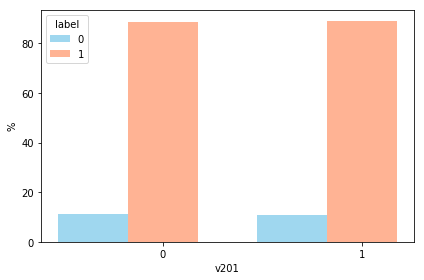

v202_label     0     1
        0  99.8  99.8
        1   0.2   0.2
1.0
Alternative hipothesis rejected



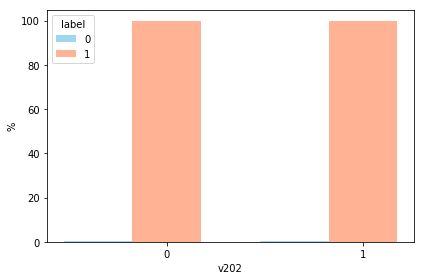

v203_label     0     1
        0  99.8  99.6
        1   0.2   0.4
0.6543975248481576
Alternative hipothesis rejected



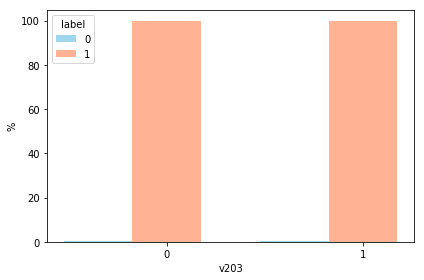

v204_label     0     1
        0  98.9  98.6
        1   1.1   1.4
0.7736337376808304
Alternative hipothesis rejected



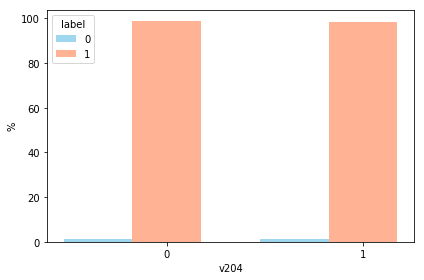

v205_label     0     1
        0  99.0  99.0
        1   1.0   1.0
1.0
Alternative hipothesis rejected



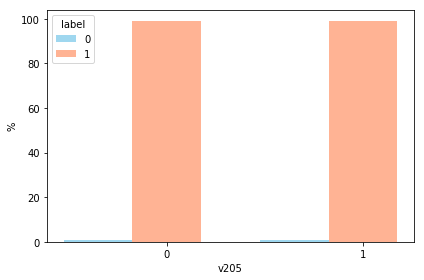

v206_label     0     1
        0  99.8  99.6
        1   0.2   0.4
0.6543975248481576
Alternative hipothesis rejected



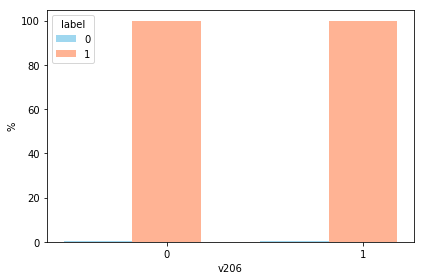

v207_label     0     1
        0  98.6  98.7
        1   1.4   1.3
0.932171301934639
Alternative hipothesis rejected



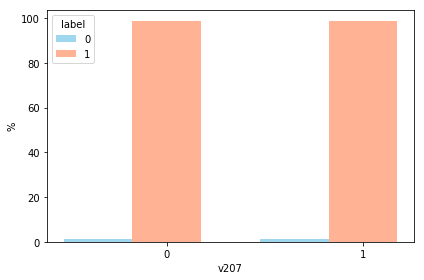

v208_label     0      1
        0  99.9  100.0
        1   0.1    0.0
0.751709543078071
Alternative hipothesis rejected



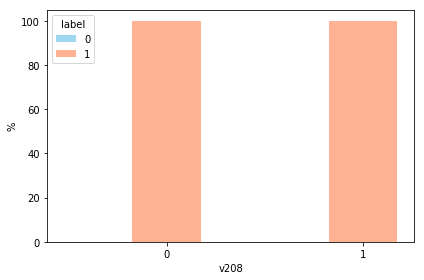

v209_label     0     1
        0  98.5  98.2
        1   1.5   1.8
0.8050575766323556
Alternative hipothesis rejected



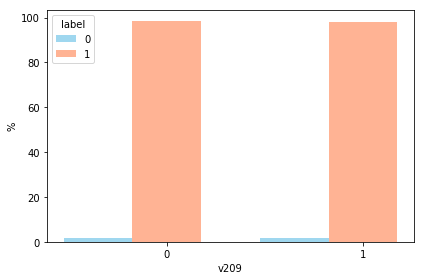

v210_label     0     1
        0  99.3  99.7
        1   0.7   0.3
0.6313883867096005
Alternative hipothesis rejected



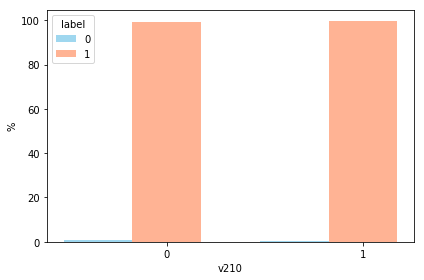

v211_label     0     1
        0  99.9  99.9
        1   0.1   0.1
1.0
Alternative hipothesis rejected



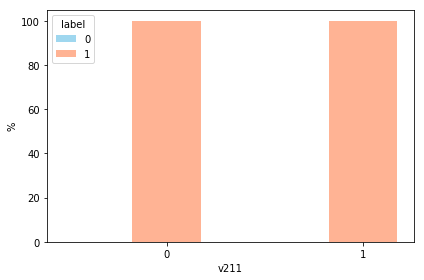

v212_label     0     1
        0  99.7  99.8
        1   0.3   0.2
0.8549167632127839
Alternative hipothesis rejected



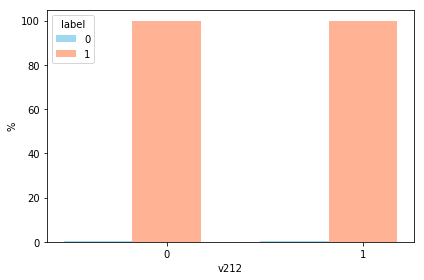

v213_label     0     1
        0  99.0  99.2
        1   1.0   0.8
0.8406926603054861
Alternative hipothesis rejected



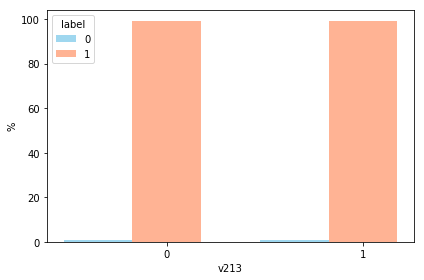

v214_label     0     1
        0  99.4  99.5
        1   0.6   0.5
0.8969711281194963
Alternative hipothesis rejected



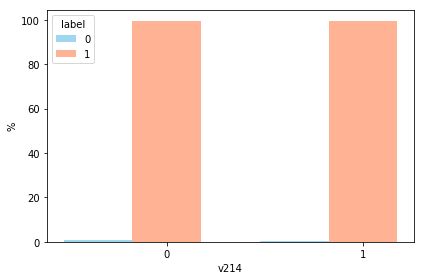

v215_label     0     1
        0  98.8  98.5
        1   1.2   1.5
0.7829172353091405
Alternative hipothesis rejected



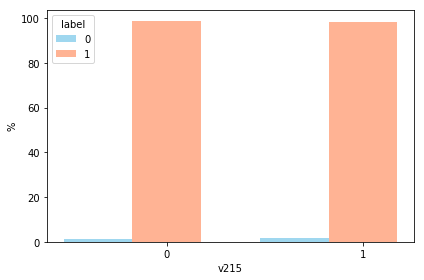

v216_label     0     1
        0  99.4  99.7
        1   0.6   0.3
0.6976715918626955
Alternative hipothesis rejected



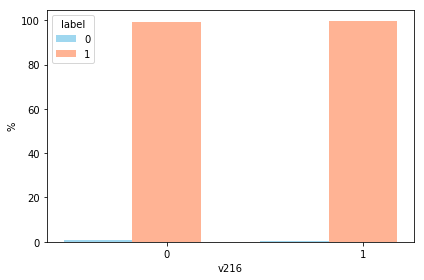

v217_label     0     1
        0  99.5  99.9
        1   0.5   0.1
0.5706428705234272
Alternative hipothesis rejected



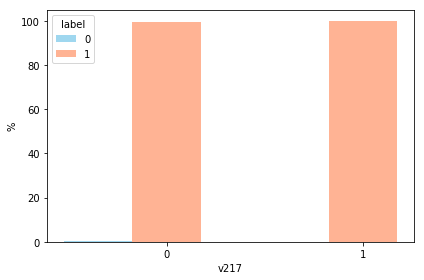

v218_label     0     1
        0  99.3  99.7
        1   0.7   0.3
0.6313883867096005
Alternative hipothesis rejected



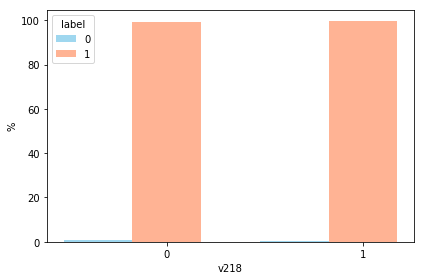

v219_label     0     1
        0  99.5  99.6
        1   0.5   0.4
0.8872567514079835
Alternative hipothesis rejected



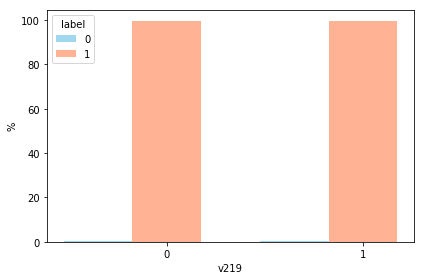

v220_label     0     1
        0  99.1  99.0
        1   0.9   1.0
0.9156721490126649
Alternative hipothesis rejected



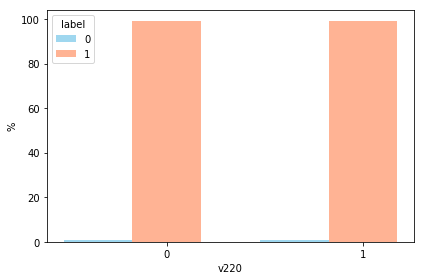

v221_label     0     1
        0  99.7  99.8
        1   0.3   0.2
0.8549167632127839
Alternative hipothesis rejected



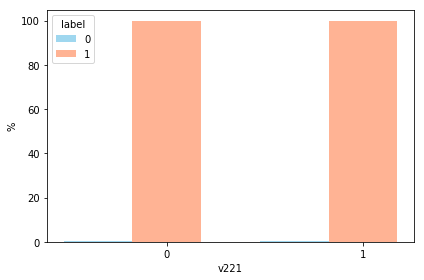

v222_label     0     1
        0  99.4  99.6
        1   0.6   0.4
0.795652994592478
Alternative hipothesis rejected



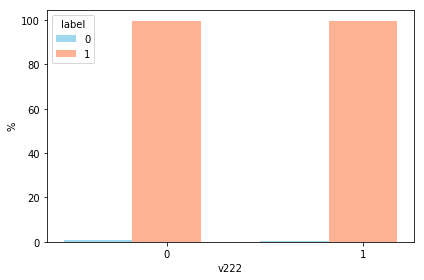

v223_label     0     1
        0  97.3  97.2
        1   2.7   2.8
0.9508043948590787
Alternative hipothesis rejected



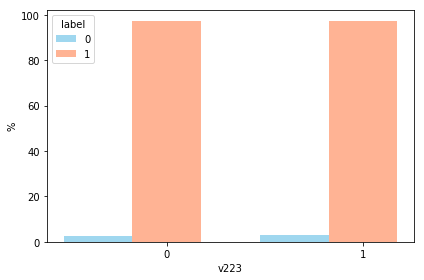

v224_label     0     1
        0  99.4  99.3
        1   0.6   0.7
0.8969711281194962
Alternative hipothesis rejected



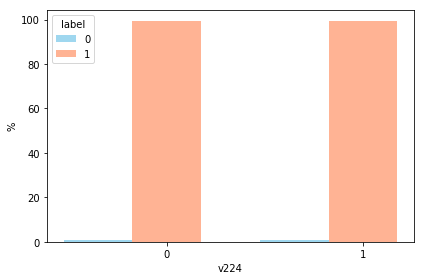

v225_label     0     1
        0  99.7  99.8
        1   0.3   0.2
0.8549167632127839
Alternative hipothesis rejected



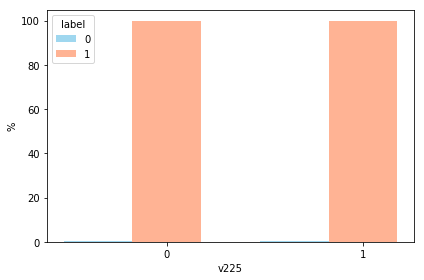

v226_label     0     1
        0  99.8  99.9
        1   0.2   0.1
0.8228890092824235
Alternative hipothesis rejected



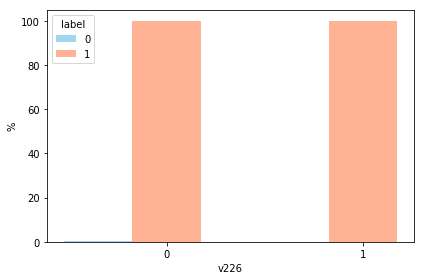

v227_label     0     1
        0  99.4  99.5
        1   0.6   0.5
0.8969711281194963
Alternative hipothesis rejected



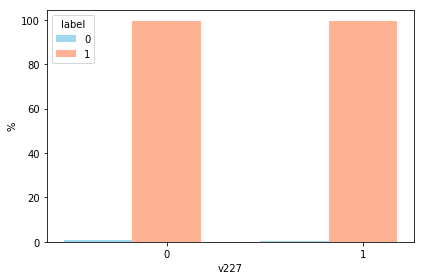

['v2', 'v3', 'v10', 'v16', 'v17', 'v18', 'v21', 'v61']


In [34]:
useful = []
for i in ints:
    
    ct = app.crosstab(i, 'label').toPandas()
    ct_rate = ct
    ct_rate['0'] = ct_rate.apply(lambda row: 100 * row['0'] / float(ct_rate['0'].sum()), axis=1)
    ct_rate['1'] = ct_rate.apply(lambda row: 100 * row['1'] / float(ct_rate['1'].sum()), axis=1)
    ct_rate = ct_rate.round(1)
    ct_rate = ct_rate.sort_values(by=ct_rate.columns[0])
    
    print ct_rate.to_string(index=False)
    ct_rate = ct_rate.drop([ct_rate.columns[0]], axis=1)
    
    # balance dataset
#     ct[0] = ct[0] * (ct[1].sum() / float(ct[0].sum()))
    
    chi, p = stats.chisquare(f_obs=ct_rate['1'], f_exp=ct_rate['0'])
    print(p)
    
    if p < 0.05:
        print('Null hipothesis rejected')
        if np.abs(ct_rate.iloc[0,0] - ct_rate.iloc[0,1]) > 10:
            useful.append(i)
    else:
        print('Alternative hipothesis rejected')
    
    print
    
    # create plot
    fig, ax = plt.subplots()
    index = np.arange(2)
    bar_width = 0.35
    opacity = 0.8

    rects1 = plt.bar(index, ct_rate.transpose()[0], bar_width,
                     alpha=opacity,
                     color='skyblue',
                     label='0')

    rects2 = plt.bar(index + bar_width, ct_rate.transpose()[1], bar_width,
                     alpha=opacity,
                     color='lightsalmon',
                     label='1')

    plt.xlabel(i)
    plt.ylabel('%')
#     plt.title('Scores by person')
    plt.xticks(index + bar_width, ('0', '1'))
    plt.legend(title='label')

    plt.tight_layout()
    plt.show()
    
print(useful)    

In [18]:
cols = app.columns
cols.remove('label')

assembler = VectorAssembler(inputCols=cols,outputCol='features')
df = assembler.transform(app)
df.cache()

DataFrame[label: int, v1: int, v2: int, v3: int, v4: int, v5: int, v6: int, v7: int, v8: int, v9: int, v10: int, v11: int, v12: int, v13: int, v14: int, v15: int, v16: int, v17: int, v18: int, v19: int, v20: int, v21: int, v22: int, v23: int, v24: int, v25: int, v26: int, v27: int, v28: double, v29: double, v30: double, v31: double, v32: double, v33: double, v34: double, v35: double, v36: double, v37: double, v38: double, v39: double, v40: double, v41: double, v42: double, v43: double, v44: double, v45: double, v46: double, v47: double, v48: double, v49: double, v50: double, v51: double, v52: double, v53: double, v54: double, v55: double, v56: double, v57: double, v58: double, v59: double, v60: int, v61: int, v62: int, v63: int, v64: int, v65: int, v66: int, v67: int, v68: int, v69: int, v70: int, v71: int, v72: int, v73: int, v74: int, v75: int, v76: int, v77: int, v78: int, v79: int, v80: int, v81: int, v82: int, v83: int, v84: int, v85: int, v86: int, v87: int, v88: int, v89: int, v

In [19]:
n = 3 # number of components for PCA
classes = 2 # label: 0, 1

pca = PCA(k=n, inputCol="features", outputCol="pca_features")

# useful = [] # useful discriminant variables
for cl in range(classes):
    print('Label = ' + str(cl))
    print
    
    model = pca.fit(df.where(df.label == cl))
    pca_pd = pd.DataFrame.from_records(model.pc.toArray(), columns=['pc-' + str(k + 1) for k in range(n)])    
    pca_pd = pd.concat([pca_pd, pd.Series(cols, name='cols')], axis=1)
    
    for i in range(n):
        component =  'pc-' + str(i + 1)
        print(component)
        print
        p = pca_pd.loc[np.abs(pca_pd[component]) > 0.1].sort_values(by=component)
        p = p[['cols', component]]
        print(p.to_string(index=False))
#         useful.extend(pca_pd['cols'].tolist())
#         print(pca_pd)
        print
    print(model.explainedVariance)
    print
    print

# useful = list(set(useful))
# useful.sort()
# print(useful)

Label = 0

pc-1

cols      pc-1
 v2 -0.505570
v60 -0.375224
v27 -0.352091
v16 -0.331380
v21 -0.327206
v24 -0.216568
v25 -0.205112
v22 -0.190684
v33 -0.179459
v18 -0.144419
v35 -0.125014
v58 -0.109134
v23 -0.104384

pc-2

cols      pc-2
 v87 -0.476011
 v58 -0.360115
v201 -0.356525
 v57 -0.269349
 v55 -0.259030
 v27 -0.235777
 v56 -0.212870
 v60  0.148624
 v16  0.221481
 v25  0.385674

pc-3

cols      pc-3
 v87 -0.502964
 v60 -0.322565
 v55 -0.259219
v201 -0.172370
 v57  0.157874
 v27  0.160093
 v61  0.197614
 v58  0.614973

[0.09557966528256082,0.07261193734586288,0.05729800144155136]


Label = 1

pc-1

cols      pc-1
 v60 -0.435186
 v18 -0.271375
 v25 -0.212278
 v35 -0.199714
 v34 -0.159623
 v36 -0.158360
 v56  0.113374
 v69  0.119138
v187  0.119138
  v3  0.123150
 v57  0.201944
 v10  0.207762
 v61  0.431053
 v58  0.443307

pc-2

cols      pc-2
 v61 -0.465509
 v18 -0.215368
 v34 -0.184619
 v12 -0.116703
 v16  0.115853
 v27  0.143475
 v69  0.153118
v187  0.153118
 v57  0.163127
 v58  0.

In [20]:
df.unpersist()

DataFrame[label: int, v1: int, v2: int, v3: int, v4: int, v5: int, v6: int, v7: int, v8: int, v9: int, v10: int, v11: int, v12: int, v13: int, v14: int, v15: int, v16: int, v17: int, v18: int, v19: int, v20: int, v21: int, v22: int, v23: int, v24: int, v25: int, v26: int, v27: int, v28: double, v29: double, v30: double, v31: double, v32: double, v33: double, v34: double, v35: double, v36: double, v37: double, v38: double, v39: double, v40: double, v41: double, v42: double, v43: double, v44: double, v45: double, v46: double, v47: double, v48: double, v49: double, v50: double, v51: double, v52: double, v53: double, v54: double, v55: double, v56: double, v57: double, v58: double, v59: double, v60: int, v61: int, v62: int, v63: int, v64: int, v65: int, v66: int, v67: int, v68: int, v69: int, v70: int, v71: int, v72: int, v73: int, v74: int, v75: int, v76: int, v77: int, v78: int, v79: int, v80: int, v81: int, v82: int, v83: int, v84: int, v85: int, v86: int, v87: int, v88: int, v89: int, v

In [27]:
# variables selected by the three methods: T-Test, Chi-Square, and PCA
cols = ['v2', 'v3', 'v10', 'v12', 'v13', 'v16', 'v17', 'v18', 
        'v21', 'v29', 'v30', 'v31', 'v32', 'v33', 'v34', 
        'v37', 'v38', 'v50', 'v51', 'v57', 'v58', 'v61']

In [28]:
# Identify multicolinearity using Variance Inflation Factor (VIF)

MAX_VIF = 5
unnecessary = [x for x in app.columns if x not in cols]

found = True
i = 0
while found:
    i += 1
    print(i)
    
    temp_app = app.drop(*unnecessary)
    temp_cols = temp_app.columns
    
    vifs = []
    for c in temp_cols:
        features = [x for x in temp_cols if x != c]
        
        assembler = VectorAssembler(inputCols=features,outputCol='features')
        temp_df = assembler.transform(temp_app)
        temp_df = temp_df.select(['features', c])
        
        lr = LinearRegression(featuresCol='features', labelCol=c, maxIter=10)
        lrModel = lr.fit(temp_df)
        trainingSummary = lrModel.summary
        if np.abs(trainingSummary.r2) == 1:
            vif = np.float('inf')
        else:
            vif =  1 / float(1 - trainingSummary.r2)
        
        vifs.append({'col' : c, 'vif' : vif})
    vifs_pd = pd.DataFrame(vifs)
    print(vifs_pd)
        
    idx = vifs_pd['vif'].idxmax()
    k = vifs_pd.loc[idx, 'col']
    v = vifs_pd.loc[idx, 'vif']
    
    print(k + ' ' + str(v))
    
    found = False    
    if v > MAX_VIF:
        unnecessary.append(k)
        found = True

1
    col        vif
0    v2   1.665493
1    v3   1.244565
2   v10   1.275100
3   v12   1.549910
4   v13   1.101268
5   v16   1.178143
6   v17   1.109990
7   v18   1.264598
8   v21   1.565187
9   v29   9.789272
10  v30  11.712717
11  v31   7.323581
12  v32   1.853636
13  v33   3.199275
14  v34   1.628926
15  v37   1.217405
16  v38   1.555040
17  v50   1.467447
18  v51   1.142174
19  v57   2.456514
20  v58   2.252506
21  v61   1.100307
v30 11.712717374671179
2
    col       vif
0    v2  1.665467
1    v3  1.243068
2   v10  1.275029
3   v12  1.549895
4   v13  1.101254
5   v16  1.177804
6   v17  1.109768
7   v18  1.264549
8   v21  1.564413
9   v29  5.657049
10  v31  6.087379
11  v32  1.807929
12  v33  3.197467
13  v34  1.628910
14  v37  1.217346
15  v38  1.554377
16  v50  1.460081
17  v51  1.142126
18  v57  2.456383
19  v58  2.251716
20  v61  1.099945
v31 6.087379480895683
3
    col       vif
0    v2  1.664867
1    v3  1.242544
2   v10  1.273639
3   v12  1.549892
4   v13  1.100698
5   v16 

In [29]:
selected = ['label']
selected.extend(vifs_pd['col'].tolist())
print(selected)

['label', 'v2', 'v3', 'v10', 'v12', 'v13', 'v16', 'v17', 'v18', 'v21', 'v29', 'v32', 'v33', 'v34', 'v37', 'v38', 'v50', 'v51', 'v57', 'v58', 'v61']


In [30]:
app_rdd = app.select(selected).rdd.map(tuple)

In [31]:
from pyspark.mllib.stat import Statistics

pearsonCorr = Statistics.corr(app_rdd)

print(pearsonCorr)

[[ 1.00000000e+00  1.81674752e-01  2.36802332e-01  2.98789648e-01
   1.83630966e-01  1.90488145e-01  6.49268736e-02  1.84648217e-01
   1.27655648e-01  1.04881812e-01  2.43280830e-01  2.21845344e-01
   2.88925921e-01  1.81120626e-01  1.05533558e-01  2.53740213e-01
   3.78105862e-01  1.43365319e-01  1.34447275e-01  1.33653823e-01
   1.73429123e-01]
 [ 1.81674752e-01  1.00000000e+00  1.46569013e-01  1.58292189e-01
   4.52184638e-02  8.52942358e-02  2.00584591e-01  1.06545760e-01
   1.80420145e-01  3.46843325e-01  2.73746586e-01  1.94001076e-01
   6.07884522e-01  4.25147044e-02  9.40404998e-02  3.14556595e-01
   2.56419827e-01  1.09129802e-01  1.18272168e-01  9.72805043e-02
   1.54509297e-01]
 [ 2.36802332e-01  1.46569013e-01  1.00000000e+00  3.03153482e-01
   7.88440068e-02  1.89368225e-01  9.35960305e-02  1.61866751e-01
   8.13097498e-02  1.02092664e-01  2.07570468e-01  1.60195675e-01
   3.30920518e-01  6.75892321e-02  3.54049513e-02  1.23026696e-01
   2.19103497e-01  1.11109359e-01  8.9

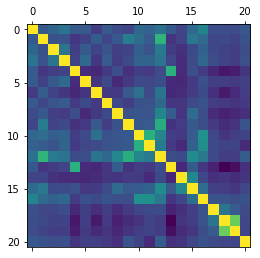

In [32]:
plt.matshow(pearsonCorr)
plt.show()

In [35]:
sc.stop()